# Imports and config setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import librosa
import soundfile as sf
import numpy as np
import os
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# Real-time optimized configuration for SUBESCO
class SUBESCOConfig:
    # Audio parameters optimized for real-time
    SAMPLE_RATE = 22050  # Reduced from 48000 for speed
    TARGET_LENGTH = 3    # Reduced from 5 seconds
    TRIM_THRESHOLD = 25  # Slightly reduced
    MAX_AMPLITUDE = 0.9
    
    # Feature parameters optimized for real-time
    N_MFCC = 20         # Reduced from 60
    N_MELS = 30         # Reduced from 80  
    N_FRAMES = 250      # Reduced from 500
    
    NUM_CLASSES = 7
    EMOTIONS = ['Neutral', 'Angry', 'Sad', 'Happy', 'Surprised', 'Fear', 'Disappointment']
    
    # Training parameters
    BATCH_SIZE = 32 #64
    LEARNING_RATE = 5e-4
    WEIGHT_DECAY = 5e-4
    NUM_EPOCHS = 60    # Reduced from 500
    PATIENCE = 25       # Reduced from 50

    # ADD: Enhanced regularization settings
    ENHANCED_DROPOUT = True
    REDUCED_LR = True
    EARLY_STOPPING = True
    
    DEVICE = torch.device('cuda')

config = SUBESCOConfig()

# Create directories
os.makedirs("subesco_augmented", exist_ok=True)
os.makedirs("subesco_processed", exist_ok=True)


d:\Anaconda\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
d:\Anaconda\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 45.0.0.
  "class": algorithms.Blowfish,
d:\Anaconda\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


# The load functions set up in case of first time pre processing

In [2]:
def load_combined_clean_dataset(subesco_path, banspemo_path=None, banglaser_path=None):
    """
    Load SUBESCO (clean studio), BanSpEmo (published), BanglaSER (published/curated)
    """
    all_paths = []
    all_labels = []

    # Load SUBESCO
    if subesco_path and os.path.exists(subesco_path):
        print("Loading SUBESCO (clean studio)...")
        subesco_paths, subesco_labels = load_subesco_dataset(subesco_path)
        all_paths.extend(subesco_paths)
        all_labels.extend(subesco_labels)

    # Load BanSpEmo
    if banspemo_path and os.path.exists(banspemo_path):
        print("Loading BanSpEmo...")
        banspemo_paths, banspemo_labels = load_banspemo_dataset(banspemo_path)
        all_paths.extend(banspemo_paths)
        all_labels.extend(banspemo_labels)

    # Load BanglaSER
    if banglaser_path and os.path.exists(banglaser_path):
        print("Loading BanglaSER...")
        banglaser_paths, banglaser_labels = load_banglaser_dataset(banglaser_path)
        all_paths.extend(banglaser_paths)
        all_labels.extend(banglaser_labels)

    # Distribution reporting
    label_counts = Counter(all_labels)
    print(f"Combined dataset loaded: {len(all_paths)} files")
    print("Combined distribution:")
    for emotion in config.EMOTIONS:
        count = label_counts.get(emotion.lower(), 0)
        print(f"  {emotion}: {count}")
    return all_paths, all_labels

def load_subesco_dataset(dataset_path):
    """Your existing SUBESCO loader - no changes needed"""
    paths = []
    labels = []
    
    # Keep all 7 SUBESCO emotions
    emotion_map = {
        'NEUTRAL': 'neutral',
        'ANGRY': 'angry', 
        'DISGUST': 'disappointment',    # Keep this
        'FEAR': 'fear',          # Keep this
        'HAPPY': 'happy',
        'SAD': 'sad',
        'SURPRISE': 'surprised'
    }
    
    print("Loading SUBESCO dataset (all 7 emotions)...")
    
    for filename in os.listdir(dataset_path):
        if filename.endswith('.wav'):
            try:
                parts = filename.replace('.wav', '').split('_')
                if len(parts) >= 7:
                    emotion_name = parts[5].upper()
                    
                    if emotion_name in emotion_map:
                        full_path = os.path.join(dataset_path, filename)
                        paths.append(full_path)
                        labels.append(emotion_map[emotion_name])
                        
            except Exception as e:
                continue
    
    return paths, labels

def load_banglaser_dataset(dataset_path):
    """Load BanglaSER correctly, supporting Actor_{id} subfolders."""
    import os
    from collections import Counter

    paths = []
    labels = []
    emotion_mapping = {
        '01': 'happy',
        '02': 'sad',
        '03': 'angry',
        '04': 'surprised',
        '05': 'neutral'
    }
    total_files, parsed_files = 0, 0

    # Loop through each Actor folder (Actor_01 .. Actor_34)
    for actor_folder in sorted(os.listdir(dataset_path)):
        actor_path = os.path.join(dataset_path, actor_folder)
        if not os.path.isdir(actor_path) or not actor_folder.lower().startswith("actor"):
            continue

        for filename in os.listdir(actor_path):
            if not filename.endswith('.wav'):
                continue
            total_files += 1
            parts = filename[:-4].split('-')
            if len(parts) != 7:
                continue
            mode, statement_type, emotion_code, intensity_code = parts[0], parts[1], parts[2], parts[3]
            # Keep only audio-only, scripted sentences (most neutral/clean)
            if mode != "03" or statement_type != "01":
                continue
            emotion = emotion_mapping.get(emotion_code)
            if not emotion:
                continue

            path = os.path.join(actor_path, filename)
            paths.append(path)
            labels.append(emotion)
            parsed_files += 1

    print(f"Loaded {parsed_files} / {total_files} BanglaSER WAV files")
    label_counts = Counter(labels)
    for emotion, count in label_counts.items():
        print(f"  {emotion}: {count}")
    return paths, labels


def load_banspemo_dataset(dataset_path):
    """Load BanSpEmo dataset with CORRECT 5-component filename parsing"""
    paths = []
    labels = []
    
    # BanSpEmo emotion mapping (same as before)
    banspemo_emotion_map = {
        '01': 'angry',     # Anger
        '02': 'disappointment',   # Disgust
        '03': 'fear',      # Fear
        '04': 'happy', # Happy
        '05': 'sad',   # Sad
        '06': 'surprised'   # Surprised
    }
    
    print("Loading BanSpEmo dataset...")
    found_emotions = Counter()
    parsed_count = 0
    total_count = 0
    
    for filename in os.listdir(dataset_path):
        if filename.endswith('.wav'):
            total_count += 1
            try:
                # Parse BanSpEmo ACTUAL 5-component structure
                base_name = filename.replace('.wav', '')
                parts = base_name.split('_')
                
                if len(parts) == 5:  # CORRECTED: 5 components, not 6
                    sentence_set = parts[0]    # ss1, ss2
                    sentence_num = parts[1]    # s1, s2, s3...
                    speaker_number = parts[2]  # sp1, sp2, sp3...
                    speaker_gender = parts[3]  # m, f
                    emotion_code = parts[4]    # 01-06
                    
                    found_emotions[emotion_code] += 1
                    
                    if emotion_code in banspemo_emotion_map:
                        full_path = os.path.join(dataset_path, filename)
                        paths.append(full_path)
                        labels.append(banspemo_emotion_map[emotion_code])
                        parsed_count += 1
                else:
                    print(f"Unexpected filename format: {filename} ({len(parts)} parts, expected 5)")
                        
            except Exception as e:
                print(f"Error parsing {filename}: {e}")
                continue
    
    # Debug output
    print(f"BanSpEmo parsing results:")
    print(f"  Total WAV files: {total_count}")
    print(f"  Successfully parsed: {parsed_count}")
    print(f"  Parse success rate: {parsed_count/total_count*100:.1f}%")
    
    print("\nEmotion distribution:")
    for code, count in sorted(found_emotions.items()):
        emotion_name = banspemo_emotion_map.get(code, "UNKNOWN")
        print(f"  Code {code} ({emotion_name}): {count} files")
    
    return paths, labels



# Audio Standardization function

In [3]:
def standardize_audio_realtime(file_path, target_length=config.TARGET_LENGTH, 
                              sample_rate=config.SAMPLE_RATE, 
                              trim_threshold=config.TRIM_THRESHOLD, 
                              max_amplitude=config.MAX_AMPLITUDE):
    """Optimized audio standardization for real-time performance"""
    try:
        # Load audio with optimized sample rate
        waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
        # Standardize length
        target_samples = int(target_length * sample_rate)
        if len(waveform) < target_samples:
            waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
        else:
            waveform = waveform[:target_samples]
        
        # Quick trim and re-pad
        waveform, _ = librosa.effects.trim(waveform, top_db=trim_threshold)
        if len(waveform) < target_samples:
            waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
        else:
            waveform = waveform[:target_samples]  # Ensure exact length
        
        # Normalize volume
        if waveform.max() > 0:
            waveform = waveform / waveform.max() * max_amplitude
        
        return waveform, sr
        
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        # Return silence if file fails
        return np.zeros(int(target_length * sample_rate)), sample_rate


# Augmentation Function

In [4]:
def augment_combined_realtime(paths, labels, target_count=300, 
                             augmented_base_path="combined_augmented"):
    """
    Augment all 7 emotions to target_count
    Same function signature as your existing function
    """
    
    # Handle no augmentation case
    if target_count is None or target_count == 0:
        print("No augmentation requested - using original combined dataset")
        return paths, labels
    
    print(f"Starting combined dataset augmentation to {target_count} samples per emotion...")
    label_counts = Counter(labels)
    all_paths, all_labels = [], []
    
    # Process all 7 emotions
    for emotion_lower in ['neutral', 'angry', 'disappointment', 'fear', 'happy', 'sad', 'surprised']:
        emotion_title = emotion_lower.title()
        original_count = label_counts.get(emotion_lower, 0)
        source_info = ""
        
        if emotion_lower in ['disgust', 'fear']:
            source_info = " (SUBESCO only)"
        else:
            source_info = " (SUBESCO + BanglaMOOD)"
            
        print(f"{emotion_title}: {original_count} original samples{source_info}")
        
        if original_count == 0:
            print(f"  Warning: No samples found for {emotion_title}")
            continue
        
        # Create directory for this emotion
        label_dir = os.path.join(augmented_base_path, emotion_lower)
        os.makedirs(label_dir, exist_ok=True)
        
        # Get paths for this emotion
        label_paths = [p for p, l in zip(paths, labels) if l == emotion_lower]
        
        # Check existing augmented files
        existing_files = [f for f in os.listdir(label_dir) if f.endswith(".wav")]
        total_current = original_count + len(existing_files)
        
        if total_current >= target_count:
            print(f"  Using existing {total_current} samples for {emotion_title}")
            # Combine original and existing augmented
            combined_paths = label_paths + [os.path.join(label_dir, f) for f in existing_files]
            combined_labels = [emotion_lower] * len(combined_paths)
            
            # Select target_count samples
            if len(combined_paths) > target_count:
                indices = np.random.choice(len(combined_paths), target_count, replace=False)
                selected_paths = [combined_paths[i] for i in indices]
                selected_labels = [combined_labels[i] for i in indices]
            else:
                selected_paths = combined_paths
                selected_labels = combined_labels
                
            all_paths.extend(selected_paths)
            all_labels.extend(selected_labels)
            continue
        
        # Clear existing and create new augmentations
        for f in existing_files:
            os.remove(os.path.join(label_dir, f))
        
        needed = target_count - original_count
        print(f"  Need to generate {needed} augmented samples for {emotion_title}")
        
        # Augmentation strategy based on emotion
        if emotion_lower in ['disgust', 'fear']:
            # More aggressive augmentation for SUBESCO-only emotions
            aug_types = ["pitch_1", "pitch_neg_1", "pitch_2", "pitch_neg_2", 
                        "stretch_1.05", "stretch_1.1", "stretch_0.95", "stretch_0.9",
                        "noise_0.005", "noise_0.008"]
        else:
            # Standard augmentation for combined emotions
            aug_types = ["pitch_1", "pitch_neg_1", "stretch_1.1", "stretch_0.9", "noise_0.005"]
        
        aug_paths, aug_labels = [], []
        aug_idx = 0
        
        while needed > 0 and aug_idx < target_count * 3:  # Prevent infinite loop
            orig_idx = aug_idx % len(label_paths)
            aug_type = aug_types[aug_idx % len(aug_types)]
            
            try:
                waveform, sr = standardize_audio_realtime(label_paths[orig_idx])
                base_name = os.path.basename(label_paths[orig_idx]).replace(".wav", "")
                
                # Apply augmentation (same logic as your existing code)
                if aug_type.startswith("pitch"):
                    if "neg" in aug_type:
                        n_steps = -float(aug_type.split("_")[2])
                    else:
                        n_steps = float(aug_type.split("_")[1])
                    augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                    file_name = f"{base_name}_pitch_{n_steps}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("stretch"):
                    rate = float(aug_type.split("_")[1])
                    augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                    # Ensure consistent length
                    target_samples = int(config.TARGET_LENGTH * config.SAMPLE_RATE)
                    if len(augmented) < target_samples:
                        augmented = np.pad(augmented, (0, target_samples - len(augmented)), mode='constant')
                    else:
                        augmented = augmented[:target_samples]
                    file_name = f"{base_name}_stretch_{rate}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("noise"):
                    noise_level = float(aug_type.split("_")[1])
                    noise = np.random.normal(0, noise_level, waveform.shape)
                    augmented = waveform + noise
                    file_name = f"{base_name}_noise_{noise_level}_{aug_idx:03d}.wav"
                
                # Save augmented file
                aug_path = os.path.join(label_dir, file_name)
                sf.write(aug_path, augmented, sr)
                aug_paths.append(aug_path)
                aug_labels.append(emotion_lower)
                needed -= 1
                
            except Exception as e:
                print(f"  Augmentation error: {e}")
            
            aug_idx += 1
        
        # Combine original and augmented
        combined_paths = label_paths + aug_paths
        combined_labels = [emotion_lower] * len(combined_paths)
        
        # Select target_count samples
        if len(combined_paths) > target_count:
            indices = np.random.choice(len(combined_paths), target_count, replace=False)
            selected_paths = [combined_paths[i] for i in indices]
            selected_labels = [combined_labels[i] for i in indices]
        else:
            selected_paths = combined_paths
            selected_labels = combined_labels
        
        all_paths.extend(selected_paths)
        all_labels.extend(selected_labels)
        
        final_count = len([l for l in all_labels if l == emotion_lower])
        print(f"  Final count for {emotion_title}: {final_count}")
    
    print(f"Total augmented samples: {len(all_paths)} ({len(all_paths)//7} per emotion)")
    return all_paths, all_labels

def augment_subesco_realtime(paths, labels, target_count=300, 
                            augmented_base_path="subesco_augmented"):
    """Optimized augmentation for SUBESCO with real-time considerations"""

    # Handle no augmentation case
    if target_count is None or target_count == 0:
        print("No augmentation requested - using original dataset only")
        return paths, labels
    
    print("Starting SUBESCO augmentation (real-time optimized)...")
    label_counts = Counter(labels)
    all_paths, all_labels = [], []
    
    for emotion_lower in set(labels):
        emotion_title = emotion_lower.title()
        original_count = label_counts[emotion_lower]
        print(f"{emotion_title}: {original_count} original samples")
        
        # Create directory for this emotion
        label_dir = os.path.join(augmented_base_path, emotion_lower)
        os.makedirs(label_dir, exist_ok=True)
        
        # Get paths for this emotion
        label_paths = [p for p, l in zip(paths, labels) if l == emotion_lower]
        
        # Check existing augmented files
        existing_files = [f for f in os.listdir(label_dir) if f.endswith(".wav")]
        total_current = original_count + len(existing_files)
        
        if total_current >= target_count:
            print(f"  Using existing {total_current} samples for {emotion_title}")
            # Use existing files
            combined_paths = label_paths + [os.path.join(label_dir, f) for f in existing_files]
            combined_labels = [emotion_lower] * len(combined_paths)
            
            # Randomly select target_count samples
            if len(combined_paths) > target_count:
                indices = np.random.choice(len(combined_paths), target_count, replace=False)
                selected_paths = [combined_paths[i] for i in indices]
                selected_labels = [combined_labels[i] for i in indices]
            else:
                selected_paths = combined_paths
                selected_labels = combined_labels
                
            all_paths.extend(selected_paths)
            all_labels.extend(selected_labels)
            continue
        
        # Clear existing and create new augmentations
        for f in existing_files:
            os.remove(os.path.join(label_dir, f))
        
        needed = target_count - original_count
        print(f"  Need to generate {needed} augmented samples for {emotion_title}")
        
        # Reduced augmentation types for speed
        aug_types = ["pitch_1", "pitch_neg_1", "stretch_1.1", "noise_0.005", "stretch_0.9"]
        
        # Extra augmentations for challenging emotions
        if emotion_lower in ["disgust", "fear", "surprise"]:  # SUBESCO challenging classes
            aug_types.extend(["pitch_2", "pitch_neg_2", "noise_0.008"])
        
        aug_paths, aug_labels = [], []
        aug_idx = 0
        
        while needed > 0 and aug_idx < target_count * 2:  # Prevent infinite loop
            orig_idx = aug_idx % len(label_paths)
            aug_type = aug_types[aug_idx % len(aug_types)]
            
            try:
                waveform, sr = standardize_audio_realtime(label_paths[orig_idx])
                base_name = os.path.basename(label_paths[orig_idx]).replace(".wav", "")
                
                # Apply augmentation
                if aug_type.startswith("pitch"):
                    if "neg" in aug_type:
                        n_steps = -float(aug_type.split("_")[2])
                    else:
                        n_steps = float(aug_type.split("_")[1])
                    augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                    file_name = f"{base_name}_pitch_{n_steps}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("stretch"):
                    rate = float(aug_type.split("_")[1])
                    augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                    # Ensure consistent length after stretching
                    target_samples = int(config.TARGET_LENGTH * config.SAMPLE_RATE)
                    if len(augmented) < target_samples:
                        augmented = np.pad(augmented, (0, target_samples - len(augmented)), mode='constant')
                    else:
                        augmented = augmented[:target_samples]
                    file_name = f"{base_name}_stretch_{rate}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("noise"):
                    noise_level = float(aug_type.split("_")[1])
                    noise = np.random.normal(0, noise_level, waveform.shape)
                    augmented = waveform + noise
                    file_name = f"{base_name}_noise_{noise_level}_{aug_idx:03d}.wav"
                
                # Save augmented file
                aug_path = os.path.join(label_dir, file_name)
                sf.write(aug_path, augmented, sr)
                aug_paths.append(aug_path)
                aug_labels.append(emotion_lower)
                needed -= 1
                
            except Exception as e:
                print(f"  Augmentation error: {e}")
            
            aug_idx += 1
        
        # Combine original and augmented
        combined_paths = label_paths + aug_paths
        combined_labels = [emotion_lower] * len(combined_paths)
        
        # Select target_count samples
        if len(combined_paths) > target_count:
            indices = np.random.choice(len(combined_paths), target_count, replace=False)
            selected_paths = [combined_paths[i] for i in indices]
            selected_labels = [combined_labels[i] for i in indices]
        else:
            selected_paths = combined_paths
            selected_labels = combined_labels
        
        all_paths.extend(selected_paths)
        all_labels.extend(selected_labels)
        
        print(f"  Final count for {emotion_title}: {len([l for l in all_labels if l == emotion_lower])}")
    
    print(f"Total augmented samples: {len(all_paths)}")
    return all_paths, all_labels

def augment_excitement_only(paths, labels, target_excitement_count=900, 
                           augmented_base_path="excitement_augmented"):
    """
    Augment only excitement emotion to target count while keeping other emotions unchanged
    
    Args:
        paths: List of audio file paths
        labels: List of corresponding emotion labels
        target_excitement_count: Number of excitement samples to target (default 900)
        augmented_base_path: Base directory for saving augmented files
    
    Returns:
        updated_paths, updated_labels: Lists with augmented excitement samples included
    """
    
    print(f"Starting excitement-only augmentation to {target_excitement_count} samples...")
    
    # Separate excitement from other emotions
    excitement_paths = [p for p, l in zip(paths, labels) if l == 'excitement']
    excitement_labels = ['excitement'] * len(excitement_paths)
    other_paths = [p for p, l in zip(paths, labels) if l != 'excitement']
    other_labels = [l for l in labels if l != 'excitement']
    
    original_excitement_count = len(excitement_paths)
    print(f"Original excitement samples: {original_excitement_count}")
    print(f"Other emotion samples: {len(other_paths)}")
    
    # Create excitement augmentation directory
    excitement_dir = os.path.join(augmented_base_path, 'excitement')
    os.makedirs(excitement_dir, exist_ok=True)
    
    # Check if we need augmentation
    if original_excitement_count >= target_excitement_count:
        print(f"No augmentation needed - already have {original_excitement_count} excitement samples")
        return paths, labels
    
    # Clear existing augmented files
    existing_files = [f for f in os.listdir(excitement_dir) if f.endswith(".wav")]
    for f in existing_files:
        os.remove(os.path.join(excitement_dir, f))
    
    needed = target_excitement_count - original_excitement_count
    print(f"Need to generate {needed} augmented excitement samples")
    
    # Aggressive augmentation types for excitement
    aug_types = [
        "pitch_1", "pitch_neg_1", "pitch_1.5", "pitch_neg_1.5", "pitch_2", "pitch_neg_2",
        "stretch_1.05", "stretch_1.1", "stretch_1.15", "stretch_0.95", "stretch_0.9", "stretch_0.85",
        "noise_0.003", "noise_0.005", "noise_0.008", "noise_0.01"
    ]
    
    augmented_excitement_paths = []
    aug_idx = 0
    
    while needed > 0 and aug_idx < target_excitement_count * 3:  # Prevent infinite loop
        orig_idx = aug_idx % len(excitement_paths)
        aug_type = aug_types[aug_idx % len(aug_types)]
        
        try:
            # Load and standardize audio (using your existing function)
            waveform, sr = standardize_audio_realtime(excitement_paths[orig_idx])
            base_name = os.path.basename(excitement_paths[orig_idx]).replace(".wav", "")
            
            # Apply augmentation based on type
            if aug_type.startswith("pitch"):
                if "neg" in aug_type:
                    n_steps = -float(aug_type.split("_")[2])
                else:
                    n_steps = float(aug_type.split("_")[1])
                augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                file_name = f"{base_name}_pitch_{n_steps}_{aug_idx:03d}.wav"
                
            elif aug_type.startswith("stretch"):
                rate = float(aug_type.split("_")[1])
                augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                # Ensure consistent length after stretching
                target_samples = int(config.TARGET_LENGTH * config.SAMPLE_RATE)
                if len(augmented) < target_samples:
                    augmented = np.pad(augmented, (0, target_samples - len(augmented)), mode='constant')
                else:
                    augmented = augmented[:target_samples]
                file_name = f"{base_name}_stretch_{rate}_{aug_idx:03d}.wav"
                
            elif aug_type.startswith("noise"):
                noise_level = float(aug_type.split("_")[1])
                noise = np.random.normal(0, noise_level, waveform.shape)
                augmented = waveform + noise
                file_name = f"{base_name}_noise_{noise_level}_{aug_idx:03d}.wav"
            
            # Save augmented file
            aug_path = os.path.join(excitement_dir, file_name)
            sf.write(aug_path, augmented, sr)
            augmented_excitement_paths.append(aug_path)
            needed -= 1
            
            if aug_idx % 50 == 0:  # Progress indicator
                print(f"  Generated {len(augmented_excitement_paths)} augmented samples...")
                
        except Exception as e:
            print(f"  Augmentation error for {excitement_paths[orig_idx]}: {e}")
        
        aug_idx += 1
    
    # Combine all paths and labels
    final_excitement_paths = excitement_paths + augmented_excitement_paths
    final_excitement_labels = ['excitement'] * len(final_excitement_paths)
    
    # If we generated more than needed, randomly select target count
    if len(final_excitement_paths) > target_excitement_count:
        indices = np.random.choice(len(final_excitement_paths), target_excitement_count, replace=False)
        final_excitement_paths = [final_excitement_paths[i] for i in indices]
        final_excitement_labels = [final_excitement_labels[i] for i in indices]
    
    # Combine with other emotions
    updated_paths = other_paths + final_excitement_paths
    updated_labels = other_labels + final_excitement_labels
    
    # Final summary
    final_counts = Counter(updated_labels)
    print(f"\nFinal dataset composition:")
    for emotion, count in sorted(final_counts.items()):
        print(f"  {emotion}: {count} samples")
    
    print(f"Total samples: {len(updated_paths)}")
    print(f"Excitement augmentation complete!")
    
    return updated_paths, updated_labels


# Feature Extraction

In [5]:
import librosa
import numpy as np
from scipy import stats, signal
from scipy.signal import find_peaks, butter, filtfilt
import noisereduce as nr
from sklearn.preprocessing import robust_scale
import warnings
warnings.filterwarnings('ignore')

def extract_comprehensive_noise_robust_features(file_path, sample_rate=config.SAMPLE_RATE, 
                                               n_mfcc=config.N_MFCC, n_mels=config.N_MELS, 
                                               n_frames=config.N_FRAMES, trim_silence=True, max_duration=3.0):
    """Comprehensive noise-robust feature extraction with ALL emotion-discriminative features"""
    
    try:
        # ===== ADVANCED NOISE REDUCTION PREPROCESSING =====
        
        # Load audio
        waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
        # Trim leading/trailing silence (optional)
        if trim_silence:
            waveform, _ = librosa.effects.trim(waveform, top_db=20)

        # Limit duration (optional)
        if max_duration is not None:
            max_samples = int(sr * max_duration)
            waveform = waveform[:max_samples]

        # 1. Advanced noise reduction
        try:
            # Estimate noise from quietest 10% of signal
            sorted_samples = np.sort(np.abs(waveform))
            noise_threshold = sorted_samples[int(len(sorted_samples) * 0.1)]
            noise_mask = np.abs(waveform) <= noise_threshold
            
            if np.any(noise_mask):
                noise_sample = waveform[noise_mask]
                # Apply noise reduction
                waveform = nr.reduce_noise(y=waveform, sr=sr, y_noise=noise_sample, 
                                         stationary=False, prop_decrease=0.8)
            else:
                # Fallback: use first 0.5 seconds as noise sample
                noise_len = min(int(sr * 0.5), len(waveform) // 4)
                noise_sample = waveform[:noise_len]
                waveform = nr.reduce_noise(y=waveform, sr=sr, y_noise=noise_sample)
        except:
            pass  # Continue without noise reduction if it fails
        
        # 2. Frequency domain filtering
        def butter_bandpass_filter(data, lowcut=80, highcut=8000, fs=sample_rate, order=5):
            nyquist = 0.5 * fs
            low = lowcut / nyquist
            high = min(highcut / nyquist, 0.99)  # Ensure below Nyquist
            b, a = butter(order, [low, high], btype='band')
            return filtfilt(b, a, data)
        
        waveform = butter_bandpass_filter(waveform)
        
        # 3. Dynamic range compression (for noisy audio)
        def compress_dynamic_range(audio, ratio=4.0, threshold=0.1):
            """Compress dynamic range to reduce noise impact"""
            abs_audio = np.abs(audio)
            mask = abs_audio > threshold
            compressed = audio.copy()
            compressed[mask] = np.sign(audio[mask]) * (
                threshold + (abs_audio[mask] - threshold) / ratio
            )
            return compressed
        
        waveform = compress_dynamic_range(waveform)
        
        # 4. Normalize with robust scaling
        waveform = librosa.util.normalize(waveform)
        
        # 5. Pre-emphasis (adjusted for noise)
        pre_emphasis = 0.95
        waveform = np.append(waveform[0], waveform[1:] - pre_emphasis * waveform[:-1])
        
        # Calculate hop length
        hop_length = len(waveform) // (n_frames - 1) if n_frames > 1 else len(waveform) // 100
        hop_length = max(hop_length, 64)
        
        # ===== CORE SPECTRAL FEATURES =====
        
        # Enhanced MFCCs with noise robustness
        mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, 
                                   hop_length=hop_length, lifter=22, n_fft=2048)
        mfcc_delta = librosa.feature.delta(mfcc, width=9)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2, width=9)
        
        # Mel spectrogram with noise handling
        mel_spec = librosa.feature.melspectrogram(
            y=waveform, sr=sr, n_mels=n_mels, hop_length=hop_length, 
            fmax=sr//2, power=2.0, n_fft=2048
        )
        log_mel = librosa.power_to_db(mel_spec, ref=np.max, top_db=80)
        
        # ===== ADVANCED SPECTRAL FEATURES =====
        
        # Basic spectral statistics
        spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr, hop_length=hop_length)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr, hop_length=hop_length)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr, hop_length=hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(y=waveform, sr=sr, hop_length=hop_length, n_bands=6)
        spectral_flatness = librosa.feature.spectral_flatness(y=waveform, hop_length=hop_length)
        
        # Multiple rolloff points for detailed spectral shape
        rolloff_75 = librosa.feature.spectral_rolloff(y=waveform, sr=sr, roll_percent=0.75, hop_length=hop_length)
        rolloff_85 = librosa.feature.spectral_rolloff(y=waveform, sr=sr, roll_percent=0.85, hop_length=hop_length)
        rolloff_95 = librosa.feature.spectral_rolloff(y=waveform, sr=sr, roll_percent=0.95, hop_length=hop_length)
        
        # ===== ADVANCED SPECTRAL ANALYSIS =====
        
        # Spectral moments (noise-robust implementation)
        stft = librosa.stft(waveform, hop_length=hop_length, n_fft=2048)
        magnitude_spectrum = np.abs(stft)
        
        spectral_skewness = []
        spectral_kurtosis = []
        spectral_slope = []
        
        freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)
        
        for frame in range(magnitude_spectrum.shape[1]):
            spectrum = magnitude_spectrum[:, frame]
            if np.sum(spectrum) > np.max(spectrum) * 0.01:  # Only process if significant energy
                # Normalize spectrum
                spectrum_norm = spectrum / (np.sum(spectrum) + 1e-10)
                
                # Calculate moments
                spectral_mean = np.sum(freqs * spectrum_norm)
                spectral_var = np.sum(((freqs - spectral_mean)**2) * spectrum_norm)
                
                if spectral_var > 1e-6:
                    skew = np.sum(((freqs - spectral_mean)**3) * spectrum_norm) / (spectral_var**1.5)
                    kurt = np.sum(((freqs - spectral_mean)**4) * spectrum_norm) / (spectral_var**2)
                    # Spectral slope using robust regression
                    valid_bins = spectrum > np.max(spectrum) * 0.05
                    if np.sum(valid_bins) > 5:
                        slope = stats.linregress(freqs[valid_bins], 
                                               np.log(spectrum[valid_bins] + 1e-10))[0]
                    else:
                        slope = 0
                else:
                    skew = kurt = slope = 0
                    
                spectral_skewness.append(np.clip(skew, -10, 10))
                spectral_kurtosis.append(np.clip(kurt, -10, 50))
                spectral_slope.append(np.clip(slope, -5, 5))
            else:
                spectral_skewness.append(0)
                spectral_kurtosis.append(0)
                spectral_slope.append(0)
        
        spectral_moments = np.array([spectral_skewness, spectral_kurtosis, spectral_slope])
        
        # ===== ENHANCED PROSODIC FEATURES =====
        
        # Robust pitch extraction
        try:
            f0 = librosa.yin(waveform, fmin=50, fmax=400, hop_length=hop_length, 
                           threshold=0.15, trough_threshold=0.1)
            f0_filled = np.nan_to_num(f0)
            
            # Advanced pitch statistics
            voiced_frames = f0_filled > 0
            if np.any(voiced_frames) and np.sum(voiced_frames) > 5:
                voiced_pitch = f0_filled[voiced_frames]
                
                pitch_mean = np.mean(voiced_pitch)
                pitch_std = np.std(voiced_pitch)
                pitch_range = np.ptp(voiced_pitch)
                pitch_median = np.median(voiced_pitch)
                
                # Voice quality measures
                if len(voiced_pitch) > 1:
                    pitch_jitter = np.std(np.diff(voiced_pitch)) / pitch_mean if pitch_mean > 0 else 0
                    pitch_shimmer = np.std(np.diff(np.log(voiced_pitch + 1e-10))) if pitch_mean > 0 else 0
                else:
                    pitch_jitter = pitch_shimmer = 0
                
                # Pitch contour analysis
                if len(voiced_pitch) > 2:
                    pitch_slope = stats.linregress(range(len(voiced_pitch)), voiced_pitch)[0]
                    # Pitch variability (coefficient of variation)
                    pitch_cv = pitch_std / pitch_mean if pitch_mean > 0 else 0
                else:
                    pitch_slope = pitch_cv = 0
                
                # Voice breaks (sudden pitch changes)
                if len(voiced_pitch) > 2:
                    pitch_diff = np.abs(np.diff(voiced_pitch))
                    voice_breaks = np.sum(pitch_diff > np.std(pitch_diff) * 2) / len(pitch_diff)
                else:
                    voice_breaks = 0
                    
            else:
                pitch_mean = pitch_std = pitch_range = pitch_median = 0
                pitch_jitter = pitch_shimmer = pitch_slope = pitch_cv = voice_breaks = 0
                
        except:
            f0_filled = np.zeros(int(len(waveform) / hop_length) + 1)
            pitch_mean = pitch_std = pitch_range = pitch_median = 0
            pitch_jitter = pitch_shimmer = pitch_slope = pitch_cv = voice_breaks = 0
        
        # Convert to frame-wise features
        target_frames = len(f0_filled)
        prosodic_features = np.array([
            np.full(target_frames, pitch_mean),
            np.full(target_frames, pitch_std),
            np.full(target_frames, pitch_range),
            np.full(target_frames, pitch_median),
            np.full(target_frames, pitch_jitter),
            np.full(target_frames, pitch_shimmer),
            np.full(target_frames, pitch_slope),
            np.full(target_frames, pitch_cv),
            np.full(target_frames, voice_breaks),
            f0_filled.reshape(1, -1)[0]  # Raw F0 contour
        ])
        
        # ===== VAD AND VOICE QUALITY FEATURES =====
        
        # Enhanced Voice Activity Detection
        frame_energy = librosa.feature.rms(y=waveform, hop_length=hop_length)[0]
        
        # Energy-based VAD
        energy_threshold = np.percentile(frame_energy, 20)  # Robust threshold
        vad_energy = (frame_energy > energy_threshold).astype(float)
        
        # Spectral-based VAD
        spectral_energy = np.sum(magnitude_spectrum**2, axis=0)
        spec_threshold = np.percentile(spectral_energy, 25)
        vad_spectral = (spectral_energy > spec_threshold).astype(float)
        
        # Combined VAD with smoothing
        vad_combined = ((vad_energy + vad_spectral) >= 1).astype(float)
        # Smooth VAD using median filter
        from scipy.ndimage import median_filter
        vad_smooth = median_filter(vad_combined, size=3)
        
        # VAD statistics
        voice_ratio = np.mean(vad_smooth)
        if len(vad_smooth) > 1:
            voice_transitions = np.sum(np.abs(np.diff(vad_smooth))) / len(vad_smooth)
        else:
            voice_transitions = 0
        
        # Pause analysis
        silence_frames = (1 - vad_smooth).astype(bool)
        if np.any(silence_frames):
            pause_duration_mean = np.mean(np.diff(np.where(np.diff(silence_frames.astype(int)))[0]))
            pause_frequency = np.sum(np.diff(silence_frames.astype(int)) == 1) / len(silence_frames)
        else:
            pause_duration_mean = pause_frequency = 0
        
        vad_features = np.array([
            vad_smooth,
            np.full_like(vad_smooth, voice_ratio),
            np.full_like(vad_smooth, voice_transitions),
            np.full_like(vad_smooth, pause_duration_mean),
            np.full_like(vad_smooth, pause_frequency)
        ])
        
        # ===== HARMONIC-PERCUSSIVE ANALYSIS =====
        
        try:
            # Enhanced harmonic-percussive separation
            harmonic, percussive = librosa.effects.hpss(waveform, margin=5.0)
            
            # Harmonic features
            harmonic_energy = librosa.feature.rms(y=harmonic, hop_length=hop_length)
            percussive_energy = librosa.feature.rms(y=percussive, hop_length=hop_length)
            hpr = harmonic_energy / (percussive_energy + 1e-8)
            
            # Harmonicity measures
            harmonic_centroid = librosa.feature.spectral_centroid(y=harmonic, sr=sr, hop_length=hop_length)
            percussive_centroid = librosa.feature.spectral_centroid(y=percussive, sr=sr, hop_length=hop_length)
            
            # Tonal features from harmonic component
            try:
                chroma = librosa.feature.chroma_stft(y=harmonic, sr=sr, hop_length=hop_length)
                tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sr, hop_length=hop_length)
            except:
                chroma = np.zeros((12, target_frames))
                tonnetz = np.zeros((6, target_frames))
                
        except:
            hpr = np.ones((1, target_frames))
            harmonic_centroid = spectral_centroid.copy()
            percussive_centroid = spectral_centroid.copy()
            chroma = np.zeros((12, target_frames))
            tonnetz = np.zeros((6, target_frames))
        
        # ===== FORMANT ANALYSIS =====
        
        # Enhanced formant estimation
        try:
            # LPC-based formant extraction (simplified but robust)
            formant_features = []
            
            # Process in overlapping windows for stability
            window_size = sr // 20  # 50ms windows
            hop_size = window_size // 2
            
            formants_f1, formants_f2, formants_f3 = [], [], []
            
            for i in range(0, len(waveform) - window_size, hop_size):
                window = waveform[i:i + window_size]
                if len(window) < window_size:
                    continue
                    
                # Apply window function
                window = window * np.hanning(len(window))
                
                # Compute spectrum and find peaks
                fft_window = np.fft.fft(window, n=4096)
                magnitude = np.abs(fft_window[:2048])
                freqs = np.fft.fftfreq(4096, 1/sr)[:2048]
                
                # Find spectral peaks (formant candidates)
                peaks, properties = find_peaks(magnitude, 
                                             height=np.max(magnitude)*0.1,
                                             distance=int(200 * 2048 / (sr/2)))  # Min 200Hz apart
                
                if len(peaks) >= 2:
                    # Sort by magnitude and take top candidates
                    peak_magnitudes = magnitude[peaks]
                    sorted_indices = np.argsort(peak_magnitudes)[::-1]
                    
                    # Extract formants with frequency constraints
                    f1 = None
                    f2 = None  
                    f3 = None
                    
                    for idx in sorted_indices:
                        freq = freqs[peaks[idx]]
                        if 200 <= freq <= 900 and f1 is None:
                            f1 = freq
                        elif 800 <= freq <= 2500 and f2 is None and freq > (f1 or 0) + 200:
                            f2 = freq
                        elif 1500 <= freq <= 4000 and f3 is None and freq > (f2 or 0) + 300:
                            f3 = freq
                    
                    formants_f1.append(f1 or 500)
                    formants_f2.append(f2 or 1500)
                    formants_f3.append(f3 or 2500)
                else:
                    formants_f1.append(500)
                    formants_f2.append(1500)
                    formants_f3.append(2500)
            
            # Average formants and create features
            if formants_f1:
                avg_f1 = np.median(formants_f1)
                avg_f2 = np.median(formants_f2)
                avg_f3 = np.median(formants_f3)
                
                # Formant-related measures
                f1_f2_ratio = avg_f1 / avg_f2 if avg_f2 > 0 else 0.5
                f2_f3_ratio = avg_f2 / avg_f3 if avg_f3 > 0 else 0.6
            else:
                avg_f1, avg_f2, avg_f3 = 500, 1500, 2500
                f1_f2_ratio, f2_f3_ratio = 0.33, 0.6
                
            formant_features = np.array([
                np.full(n_frames, avg_f1),
                np.full(n_frames, avg_f2),
                np.full(n_frames, avg_f3),
                np.full(n_frames, f1_f2_ratio),
                np.full(n_frames, f2_f3_ratio)
            ])
            
        except:
            formant_features = np.array([
                np.full(n_frames, 500),   # F1
                np.full(n_frames, 1500),  # F2
                np.full(n_frames, 2500),  # F3
                np.full(n_frames, 0.33),  # F1/F2 ratio
                np.full(n_frames, 0.6)    # F2/F3 ratio
            ])
        
        # ===== VOICE QUALITY MEASURES =====
        
        # Harmonics-to-Noise Ratio (enhanced)
        try:
            hnr_values = []
            frame_size = sr // 20  # 50ms frames
            
            for i in range(0, len(harmonic) - frame_size, frame_size // 2):
                h_frame = harmonic[i:i + frame_size]
                n_frame = waveform[i:i + frame_size] - h_frame  # Noise component
                
                h_power = np.sum(h_frame**2)
                n_power = np.sum(n_frame**2)
                
                if n_power > 1e-10 and h_power > 1e-10:
                    hnr = 10 * np.log10(h_power / n_power)
                    hnr = np.clip(hnr, -20, 30)
                else:
                    hnr = 0
                    
                hnr_values.append(hnr)
            
            avg_hnr = np.mean(hnr_values) if hnr_values else 0
            hnr_feature = np.full((1, n_frames), avg_hnr)
            
        except:
            hnr_feature = np.zeros((1, n_frames))
        
        # ===== TEMPORAL AND RHYTHM FEATURES =====
        
        # Enhanced rhythm analysis
        try:
            tempo, beats = librosa.beat.beat_track(y=waveform, sr=sr, hop_length=hop_length)
            
            if len(beats) > 2:
                beat_intervals = np.diff(beats * hop_length / sr)  # Convert to seconds
                rhythm_regularity = 1.0 / (np.std(beat_intervals) + 1e-8)
                rhythm_strength = np.var(beat_intervals)
                beat_consistency = 1.0 - (np.std(beat_intervals) / (np.mean(beat_intervals) + 1e-8))
            else:
                rhythm_regularity = rhythm_strength = beat_consistency = 0
                
            # Onset analysis
            onset_frames = librosa.onset.onset_detect(y=waveform, sr=sr, hop_length=hop_length)
            onset_rate = len(onset_frames) / (len(waveform) / sr) if len(waveform) > 0 else 0
            
            rhythm_features = np.array([
                np.full(n_frames, tempo),
                np.full(n_frames, rhythm_regularity),
                np.full(n_frames, rhythm_strength),
                np.full(n_frames, beat_consistency),
                np.full(n_frames, onset_rate)
            ])
            
        except:
            rhythm_features = np.zeros((5, n_frames))
        
        # ===== ADDITIONAL SPECTRAL DYNAMICS =====
        
        # Spectral flux (rate of spectral change)
        spectral_flux = np.zeros(magnitude_spectrum.shape[1])
        for i in range(1, magnitude_spectrum.shape[1]):
            flux = np.sum((magnitude_spectrum[:, i] - magnitude_spectrum[:, i-1])**2)
            spectral_flux[i] = flux
        spectral_flux[0] = spectral_flux[1] if len(spectral_flux) > 1 else 0
        
        # Spectral entropy
        spectral_entropy = []
        for frame in range(magnitude_spectrum.shape[1]):
            spectrum = magnitude_spectrum[:, frame]
            if np.sum(spectrum) > 1e-10:
                spectrum_norm = spectrum / np.sum(spectrum)
                entropy = -np.sum(spectrum_norm * np.log2(spectrum_norm + 1e-10))
            else:
                entropy = 0
            spectral_entropy.append(entropy)
        
        # Zero crossing rate dynamics
        zcr = librosa.feature.zero_crossing_rate(waveform, hop_length=hop_length)
        zcr_variance = np.var(zcr) * np.ones((1, zcr.shape[1]))
        zcr_delta = librosa.feature.delta(zcr)
        
        # RMS energy dynamics
        rms_energy = librosa.feature.rms(y=waveform, hop_length=hop_length)
        rms_delta = librosa.feature.delta(rms_energy)
        rms_acceleration = librosa.feature.delta(rms_energy, order=2)
        
        # Energy contour analysis
        energy_mean = np.mean(rms_energy)
        energy_std = np.std(rms_energy)
        energy_range = np.ptp(rms_energy)
        if len(rms_energy[0]) > 1:
            energy_slope = stats.linregress(range(len(rms_energy[0])), rms_energy[0])[0]
        else:
            energy_slope = 0
        
        energy_dynamics = np.array([
            np.full(n_frames, energy_mean),
            np.full(n_frames, energy_std),
            np.full(n_frames, energy_range),
            np.full(n_frames, energy_slope)
        ])
        
        # ===== FEATURE COMBINATION WITH ROBUST NORMALIZATION =====
        
        def pad_or_trim(feature, target_frames):
            """Robust padding/trimming with shape validation"""
            if feature.ndim == 1:
                feature = feature.reshape(1, -1)
            
            if feature.shape[1] < target_frames:
                pad_width = target_frames - feature.shape[1]
                feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='edge')
            elif feature.shape[1] > target_frames:
                feature = feature[:, :target_frames]
            return feature
        
        def robust_normalize_feature(feature):
            """Robust normalization using median and MAD"""
            # Handle NaN and inf values
            feature = np.nan_to_num(feature, nan=0.0, posinf=1.0, neginf=-1.0)
            
            # Robust normalization using median and MAD
            median = np.median(feature, axis=1, keepdims=True)
            mad = np.median(np.abs(feature - median), axis=1, keepdims=True)
            
            # Use MAD with consistency constant
            normalized = (feature - median) / (mad * 1.4826 + 1e-8)
            
            # Clip extreme values
            normalized = np.clip(normalized, -5, 5)
            
            return normalized.astype(np.float32)
        
        # Combine ALL features
        all_features = [
            # Core spectral features (60)
            robust_normalize_feature(pad_or_trim(mfcc, n_frames)),                           # 20
            robust_normalize_feature(pad_or_trim(mfcc_delta, n_frames)),                     # 20
            robust_normalize_feature(pad_or_trim(mfcc_delta2, n_frames)),                    # 20
            
            # Mel and spectral features (41)
            robust_normalize_feature(pad_or_trim(log_mel, n_frames)),                        # 30
            robust_normalize_feature(pad_or_trim(spectral_centroid, n_frames)),              # 1
            robust_normalize_feature(pad_or_trim(spectral_rolloff, n_frames)),               # 1
            robust_normalize_feature(pad_or_trim(rolloff_75, n_frames)),                     # 1
            robust_normalize_feature(pad_or_trim(rolloff_85, n_frames)),                     # 1
            robust_normalize_feature(pad_or_trim(rolloff_95, n_frames)),                     # 1
            robust_normalize_feature(pad_or_trim(spectral_bandwidth, n_frames)),             # 1
            robust_normalize_feature(pad_or_trim(spectral_contrast, n_frames)),              # 7
            robust_normalize_feature(pad_or_trim(spectral_flatness, n_frames)),              # 1
            robust_normalize_feature(pad_or_trim(spectral_moments, n_frames)),               # 3
            
            # Prosodic features (10)
            robust_normalize_feature(pad_or_trim(prosodic_features[:10], n_frames)),         # 10
            
            # VAD and voice activity (5)
            robust_normalize_feature(pad_or_trim(vad_features, n_frames)),                   # 5
            
            # Harmonic analysis (16)
            robust_normalize_feature(pad_or_trim(hpr, n_frames)),                            # 1
            robust_normalize_feature(pad_or_trim(harmonic_centroid, n_frames)),              # 1
            robust_normalize_feature(pad_or_trim(percussive_centroid, n_frames)),            # 1
            robust_normalize_feature(pad_or_trim(chroma, n_frames)),                         # 12
            robust_normalize_feature(pad_or_trim(tonnetz, n_frames)),                        # 6
            
            # Formant features (5)
            robust_normalize_feature(pad_or_trim(formant_features, n_frames)),               # 5
            
            # Voice quality (1)
            robust_normalize_feature(pad_or_trim(hnr_feature, n_frames)),                    # 1
            
            # Rhythm and temporal (5)
            robust_normalize_feature(pad_or_trim(rhythm_features, n_frames)),                # 5
            
            # Spectral dynamics (8)
            robust_normalize_feature(pad_or_trim(np.array([spectral_flux]), n_frames)),      # 1
            robust_normalize_feature(pad_or_trim(np.array([spectral_entropy]), n_frames)),   # 1
            robust_normalize_feature(pad_or_trim(zcr, n_frames)),                            # 1
            robust_normalize_feature(pad_or_trim(zcr_variance, n_frames)),                   # 1
            robust_normalize_feature(pad_or_trim(zcr_delta, n_frames)),                      # 1
            robust_normalize_feature(pad_or_trim(rms_energy, n_frames)),                     # 1
            robust_normalize_feature(pad_or_trim(rms_delta, n_frames)),                      # 1
            robust_normalize_feature(pad_or_trim(rms_acceleration, n_frames)),               # 1
            
            # Energy dynamics (4)
            robust_normalize_feature(pad_or_trim(energy_dynamics, n_frames)),                # 4
        ]
        
        # Total: 60 + 41 + 10 + 5 + 16 + 5 + 1 + 5 + 8 + 4 = 155 features
        combined_features = np.concatenate(all_features, axis=0)
        
        # Final validation
        if np.any(np.isnan(combined_features)) or np.any(np.isinf(combined_features)):
            combined_features = np.nan_to_num(combined_features, nan=0.0, posinf=1.0, neginf=-1.0)
        
        return combined_features.astype(np.float32)  # Shape: (155, n_frames)
        
    except Exception as e:
        print(f"Comprehensive feature extraction error for {file_path}: {e}")
        import traceback
        traceback.print_exc()
        # Return zeros if extraction fails
        return np.zeros((166, n_frames), dtype=np.float32)

def  compute_features_batch(paths, batch_size=100):
    """Batch processing for faster feature computation"""
    features = []
    total_batches = (len(paths) + batch_size - 1) // batch_size
    
    print(f"Computing features for {len(paths)} files in {total_batches} batches...")
    
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i + batch_size]
        batch_features = []
        
        for j, file_path in enumerate(batch_paths):
            if (i + j) % 200 == 0:
                print(f"  Processed {i + j}/{len(paths)} files...")
            
            feat = extract_comprehensive_noise_robust_features(file_path)
            batch_features.append(feat)
        
        features.extend(batch_features)
        
        # Clear memory periodically
        if i % (batch_size * 10) == 0:
            import gc
            gc.collect()
    
    print("Feature extraction completed!")
    return features


# Multiple model setup for testing

In [6]:
class ClassAwareRealtimeCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(ClassAwareRealtimeCNNTransformer, self).__init__()
        
        # Shared feature extractor
        self.shared_cnn = nn.Sequential(
            nn.Conv1d(166, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Class-specific branches for problematic classes
        self.excitement_branch = nn.Conv1d(256, 64, kernel_size=1)
        self.fear_branch = nn.Conv1d(256, 64, kernel_size=1)
        self.neutral_branch = nn.Conv1d(256, 64, kernel_size=1)
        
        # Enhanced transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256 + 64*3,  # Combined features
            nhead=8,
            dim_feedforward=512,
            dropout=0.15,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Focal loss compatible classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * (256 + 64*3), 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Shared features
        shared_features = self.shared_cnn(x)  # (batch, 256, 32)
        
        # Class-specific features
        excitement_features = self.excitement_branch(shared_features)
        fear_features = self.fear_branch(shared_features)
        neutral_features = self.neutral_branch(shared_features)
        
        # Combine all features
        combined_features = torch.cat([
            shared_features, excitement_features, fear_features, neutral_features
        ], dim=1)  # (batch, 256+64*3, 32)
        
        # Transformer processing
        transformer_in = combined_features.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        # Classification
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        
        return output

class MultiScaleCNNTransformer(nn.Module):
    """Multi-scale CNN-Transformer for emotion recognition with temporal pattern capture at different scales"""
    
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(MultiScaleCNNTransformer, self).__init__()
        
        # Multi-scale CNN branches - capture patterns at different temporal scales
        self.scale1_branch = nn.Sequential(
            # Small kernel - captures fine-grained patterns
            nn.Conv1d(166, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.AdaptiveMaxPool1d(32)
        )
        
        self.scale2_branch = nn.Sequential(
            # Medium kernel - captures medium-term patterns  
            nn.Conv1d(166, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.AdaptiveMaxPool1d(32)
        )
        
        self.scale3_branch = nn.Sequential(
            # Large kernel - captures long-term patterns
            nn.Conv1d(166, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Feature fusion layer - combine multi-scale features
        self.feature_fusion = nn.Sequential(
            nn.Conv1d(384, 256, kernel_size=1),  # 3 branches * 128 = 384
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.2)
        )
        
        # Cross-scale attention mechanism
        self.cross_scale_attention = nn.MultiheadAttention(
            embed_dim=256,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Enhanced transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.2,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Additional transformer for temporal modeling
        temporal_encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=4,
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True
        )
        self.temporal_transformer = nn.TransformerEncoder(temporal_encoder_layer, num_layers=1)
        
        # Global feature aggregation
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        
        # Enhanced classifier with residual connections
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256 + 256 * 2, 512),  # Multi-scale + global features
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
        # Learnable scale importance weights
        self.scale_weights = nn.Parameter(torch.ones(3) / 3)  # Initialize equally
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Multi-scale feature extraction
        scale1_features = self.scale1_branch(x)  # (batch, 128, 32)
        scale2_features = self.scale2_branch(x)  # (batch, 128, 32) 
        scale3_features = self.scale3_branch(x)  # (batch, 128, 32)
        
        # Apply learnable scale weights
        scale_weights_norm = F.softmax(self.scale_weights, dim=0)
        scale1_weighted = scale1_features * scale_weights_norm[0]
        scale2_weighted = scale2_features * scale_weights_norm[1]
        scale3_weighted = scale3_features * scale_weights_norm[2]
        
        # Concatenate multi-scale features
        multi_scale_features = torch.cat([
            scale1_weighted, scale2_weighted, scale3_weighted
        ], dim=1)  # (batch, 384, 32)
        
        # Feature fusion
        fused_features = self.feature_fusion(multi_scale_features)  # (batch, 256, 32)
        
        # Cross-scale attention for feature refinement
        fused_features_transposed = fused_features.permute(0, 2, 1)  # (batch, 32, 256)
        attended_features, attention_weights = self.cross_scale_attention(
            fused_features_transposed, 
            fused_features_transposed, 
            fused_features_transposed
        )
        
        # Primary transformer processing
        transformer_out = self.transformer(attended_features)  # (batch, 32, 256)
        
        # Additional temporal modeling
        temporal_out = self.temporal_transformer(transformer_out)  # (batch, 32, 256)
        
        # Combine transformer outputs with residual connection
        combined_features = transformer_out + temporal_out  # (batch, 32, 256)
        
        # Global feature extraction for robust classification
        global_features = combined_features.permute(0, 2, 1)  # (batch, 256, 32)
        global_avg = self.global_pool(global_features).squeeze(-1)  # (batch, 256)
        global_max = self.global_max_pool(global_features).squeeze(-1)  # (batch, 256) 
        global_combined = torch.cat([global_avg, global_max], dim=1)  # (batch, 512)
        
        # Prepare features for classification
        flattened_local = combined_features.reshape(batch_size, -1)  # (batch, 32*256)
        
        # Combine local and global features
        final_features = torch.cat([flattened_local, global_combined], dim=1)
        
        # Classification
        output = self.classifier(final_features)
        
        return output
    
    def get_attention_weights(self, x):
        """Get attention weights for visualization/analysis"""
        with torch.no_grad():
            batch_size = x.size(0)
            
            # Extract multi-scale features
            scale1_features = self.scale1_branch(x)
            scale2_features = self.scale2_branch(x) 
            scale3_features = self.scale3_branch(x)
            
            # Apply scale weights
            scale_weights_norm = F.softmax(self.scale_weights, dim=0)
            multi_scale_features = torch.cat([
                scale1_features * scale_weights_norm[0],
                scale2_features * scale_weights_norm[1], 
                scale3_features * scale_weights_norm[2]
            ], dim=1)
            
            # Get fused features
            fused_features = self.feature_fusion(multi_scale_features)
            fused_features_transposed = fused_features.permute(0, 2, 1)
            
            # Get attention weights
            _, attention_weights = self.cross_scale_attention(
                fused_features_transposed,
                fused_features_transposed, 
                fused_features_transposed
            )
            
            return {
                'scale_weights': scale_weights_norm.cpu(),
                'attention_weights': attention_weights.cpu(),
                'multi_scale_features': {
                    'scale1': scale1_features.cpu(),
                    'scale2': scale2_features.cpu(), 
                    'scale3': scale3_features.cpu()
                }
            }
    
class Enhanced166FeatureCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(Enhanced166FeatureCNNTransformer, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(166, 64, kernel_size=5, padding=2),  # Updated input size
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.AdaptiveMaxPool1d(32)
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.3,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        return output

class GapControlledRealtimeCNNTransformer(nn.Module):
    """Enhanced model with advanced regularization for gap control"""
    
    def __init__(self, num_classes=config.NUM_CLASSES, dropout_rate=0.5):
        super(GapControlledRealtimeCNNTransformer, self).__init__()
        
        self.dropout_rate = dropout_rate
        
        # Enhanced CNN with progressive dropout
        self.cnn = nn.Sequential(
            nn.Conv1d(166, 64, kernel_size=5, padding=2),  # Your 102 features
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(self.dropout_rate),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Enhanced transformer with layer normalization
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.3,
            batch_first=True,
            norm_first=True  # Pre-norm for better training stability
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Regularized classifier with residual connection
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 512),
            nn.LayerNorm(512),  # Layer norm instead of batch norm
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate * 0.8),
            
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        return output
    
class UltraEnhanced120FeatureCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES, dropout_rate=0.5):
        super(UltraEnhanced120FeatureCNNTransformer, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(166, 128, kernel_size=7, padding=3),  # Larger kernel for more features
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.MaxPool1d(2),
            
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout1d(dropout_rate),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Enhanced transformer for complex feature relationships
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=16,  # More attention heads for complex features
            dim_feedforward=1024,
            dropout=0.3,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        
        # Enhanced classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * 512, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        return output

class ComprehensiveNoiseRobustModel(nn.Module):
    """Model for comprehensive 155-feature emotion recognition"""
    
    def __init__(self, num_classes=config.NUM_CLASSES, dropout_rate=0.5): #.4
        super(ComprehensiveNoiseRobustModel, self).__init__()
        
        # Enhanced CNN for rich feature set
        self.cnn = nn.Sequential(
            nn.Conv1d(166, 128, kernel_size=7, padding=3),  # Large kernel for complex features
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.5), #.2
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.5), #.3
            nn.MaxPool1d(2),
            
            nn.Conv1d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout1d(dropout_rate),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Multi-head attention transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=384,
            nhead=12,  # More heads for complex feature relationships
            dim_feedforward=768,
            dropout=0.2,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        
        # Feature fusion layer
        self.feature_fusion = nn.Sequential(
            nn.Linear(32 * 384, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Multi-layer classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.4),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # CNN feature extraction
        cnn_out = self.cnn(x)  # (batch, 384, 32)
        
        # Transformer attention
        transformer_in = cnn_out.permute(0, 2, 1)  # (batch, 32, 384)
        transformer_out = self.transformer(transformer_in)
        
        # Flatten for classification
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        
        # Feature fusion
        fused = self.feature_fusion(flattened)
        
        # Classification
        output = self.classifier(fused)
        
        return output



In [7]:
class SUBESCODataset(Dataset):
    def __init__(self, features, labels, label_map):
        self.features = features
        self.labels = [label_map[l] for l in labels]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


# Multiple Train functions for different models

In [8]:
def train_epoch(model, train_loader, optimizer, criterion):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def train_with_progressive_lr(model, train_loader, val_loader, num_epochs=40):
    """Train with aggressive LR reduction after epoch 15"""
    model = model.to(config.DEVICE)
    
    # Start with your current successful settings
    optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-7)
    
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                                dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    best_val_accuracy = 0.0
    save_path = "SUBESCO_Realtime_Model.pth"

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    for epoch in range(num_epochs):
        # AGGRESSIVE LR reduction after epoch 15 to control overfitting
        # if epoch == 15:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = 1e-4  # Reduce by 3x
        #     print(f"  📉 Reduced LR to {optimizer.param_groups[0]['lr']:.6f} at epoch {epoch+1}")
        
        # if epoch == 25:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = 3e-5  # Reduce further
        #     print(f"  📉 Reduced LR to {optimizer.param_groups[0]['lr']:.6f} at epoch {epoch+1}")
        
        # if epoch == 32:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = 1e-5  # Final reduction
        #     print(f"  📉 Reduced LR to {optimizer.param_groups[0]['lr']:.6f} at epoch {epoch+1}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        gap = abs(train_acc - val_acc)
        print(f"Epoch {epoch+1:2d}/{num_epochs} | Train: {train_acc:.3f} | "
              f"Val: {val_acc:.3f} | Gap: {gap:.3f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
        
    
    model.load_state_dict(torch.load(save_path))
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    return model

def train_best_known_config(model, train_loader, val_loader, num_epochs=300, patience=20):
    """Fixed training function with proper gap control"""
    model = model.to(config.DEVICE)
    
    # FIXED: Reasonable learning rate with proper scheduler
    # optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)  # Reduced from 1e-2
    # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=8, min_lr=1e-3)  # Fixed min_lr
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
    steps_per_epoch = len(train_loader)
    from torch.optim.lr_scheduler import OneCycleLR
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=num_epochs, #50
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3  # 30% ramp up, 70% anneal down
    )
    
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32).to(config.DEVICE)

    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    def monitor_gap(train_acc, val_acc, epoch):
        gap = abs(train_acc - val_acc)
        if gap > 0.10:  # Reduced threshold for earlier detection
            print(f"  ⚠️  Gap warning: {gap:.3f} at epoch {epoch}")
        return gap
    
    best_val_accuracy = 0.0
    patience_counter = 0
    save_path = "Final_MultiScale_Realtime_Model.pth"
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    print(f"🎯 Training with LR: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"📊 Gap monitoring threshold: 0.12")
    
    # SINGLE TRAINING LOOP - Fixed structure
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(targets.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(targets.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        epoch_time = time.time() - start_time
        gap = monitor_gap(train_accuracy, val_accuracy, epoch+1)
        
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train: {train_accuracy:.3f} | Val: {val_accuracy:.3f} | "
              f"Gap: {gap:.3f} | Loss: {val_loss:.4f} | "
              f"Time: {epoch_time:.1f}s | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # AGGRESSIVE gap control
        if gap > 0.10:
            print(f"  🛑 Stopping due to excessive overfitting gap: {gap:.3f}")
            break
        
        # Learning rate scheduling (now works properly)
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_accuracy)
        new_lr = optimizer.param_groups[0]['lr']
        
        if new_lr < old_lr:
            print(f"  📉 LR reduced: {old_lr:.6f} → {new_lr:.6f}")
        
        # Early stopping and model saving
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load best model
    model.load_state_dict(torch.load(save_path))
    
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    
    print(f"Training completed! Best validation accuracy: {best_val_accuracy:.4f}")
    return model

from torch.optim.lr_scheduler import OneCycleLR
def train_with_advanced_gap_control(model, train_loader, val_loader, num_epochs=100, target_gap=0.10):
    """Advanced training with multiple gap control mechanisms"""
    model = model.to(config.DEVICE)
    
    # FIXED: Proper OneCycleLR configuration
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-7)  # Higher weight decay
    steps_per_epoch = len(train_loader)
    
    # Match scheduler epochs to actual training epochs
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=200,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,
        div_factor=10,      # Start LR = max_lr/10
        final_div_factor=100 # End LR = max_lr/100
    )
    
    class_weights = torch.tensor([1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0], 
                                dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)  # Higher smoothing
    
    best_val_accuracy = 0.0
    save_path = "Class_Aware_Realtime_Model.pth"
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    # Gap control variables
    gap_threshold = target_gap
    consecutive_high_gaps = 0
    best_gap_epoch = 0
    best_gap = float('inf')
    
    print(f"🎯 Training with target gap: {target_gap:.1%}")
    print(f"📊 Advanced gap control enabled")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # === TRAINING PHASE ===
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()  # Step after each batch for OneCycleLR
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(targets.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        
        # === VALIDATION PHASE ===
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(targets.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # === ADVANCED GAP CONTROL ===
        gap = abs(train_accuracy - val_accuracy)
        epoch_time = time.time() - start_time
        
        # Track best gap
        if gap < best_gap:
            best_gap = gap
            best_gap_epoch = epoch + 1
        
        # Gap monitoring
        if gap > gap_threshold:
            consecutive_high_gaps += 1
            print(f"  ⚠️  Gap warning: {gap:.3f} (target: {gap_threshold:.3f}) - Strike {consecutive_high_gaps}")
        else:
            consecutive_high_gaps = 0
        
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train: {train_accuracy:.3f} | Val: {val_accuracy:.3f} | "
              f"Gap: {gap:.3f} | Loss: {val_loss:.4f} | "
              f"Time: {epoch_time:.1f}s | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # === EARLY STOPPING STRATEGIES ===
        
        # Strategy 1: Stop if gap exceeds threshold for too long
        if consecutive_high_gaps >= 5:
            print(f"  🛑 Stopping: Gap exceeded {gap_threshold:.3f} for 5 consecutive epochs")
            break
        
        # Strategy 2: Hard stop at extreme gap
        if gap > 0.20:
            print(f"  🛑 Emergency stop: Gap too extreme ({gap:.3f})")
            break
        
        # Strategy 3: Save best model (highest val accuracy with acceptable gap)
        if val_accuracy > best_val_accuracy and gap <= gap_threshold * 1.5:  # Allow 50% tolerance
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f} (Gap: {gap:.3f})")
        
        # Strategy 4: Alternative save - best gap model
        if gap < best_gap:
            torch.save(model.state_dict(), "best_gap_model.pth")
    
    # === POST-TRAINING MODEL SELECTION ===
    print(f"\n📊 Training Summary:")
    print(f"   Best validation accuracy: {best_val_accuracy:.4f}")
    print(f"   Best gap achieved: {best_gap:.3f} at epoch {best_gap_epoch}")
    
    # Choose best model based on gap vs accuracy trade-off
    if best_val_accuracy > 0 and os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
        print(f"   Using best accuracy model: {best_val_accuracy:.4f}")
    elif os.path.exists("best_gap_model.pth"):
        model.load_state_dict(torch.load("best_gap_model.pth"))
        print(f"   Using best gap model: gap {best_gap:.3f}")
    
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    
    return model

def plot_training_history(train_acc, val_acc, train_loss, val_loss):
    """Plot training history with best epoch marker"""
    
    # Find best epoch (lowest validation loss)
    best_epoch = np.argmin(val_loss) + 1  # +1 because epochs start from 1
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy', alpha=0.7)
    plt.plot(epochs, val_acc, label='Validation Accuracy', alpha=0.7)
    plt.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, 
                label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss', alpha=0.7)
    plt.plot(epochs, val_loss, label='Validation Loss', alpha=0.7)
    plt.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2,
                label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print best epoch information
    print(f"Best epoch: {best_epoch}")
    print(f"Best validation loss: {val_loss[best_epoch-1]:.4f}")
    print(f"Best validation accuracy: {val_acc[best_epoch-1]:.4f}")


# Evaluation Function

In [9]:
def evaluate_realtime_model(model, test_loader, label_map_inv):
    """Evaluate the real-time model"""
    model.eval()
    all_preds, all_labels = [], []
    
    print("Evaluating model...")
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    present_classes = [label_map_inv[i] for i in sorted(set(all_labels))]
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=present_classes, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=present_classes, yticklabels=present_classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("SUBESCO Real-Time Model Confusion Matrix")
    plt.show()
    
    return accuracy


# Original Pre Processing Setup for audio files in case cache isnt available. Takes over 8 hours.

In [ ]:

# """Complete training pipeline for SUBESCO real-time model"""

# print("=" * 60)
# print("SUBESCO + BanglaMOOD Real-Time Emotion Recognition Training")
# print("=" * 60)

# # CHANGE: Add BanglaSER path
# subesco_path = "H:\\SUBESCO"
# banspemo_path = "H:\\BANSpEmo A Bangla Language Emotional Speech Recognition Dataset\\BANSpEmo A Bangla Language Emotional Speech Recognition Dataset\\BANSpEmo Dataset"
# banglaser_path = "H:\\BanglaSER"
#  # Load combined dataset
# paths, labels = load_combined_clean_dataset(subesco_path, banspemo_path, banglaser_path)

# if len(paths) == 0:
#     print("No data found! Check your dataset path.")

# # CHANGE: Augment all to same amount (e.g., 800 per emotion)
# augmented_paths, augmented_labels = augment_combined_realtime(paths, labels, target_count=0)
# # augmented_paths, augmented_labels = augment_excitement_only(
# #     paths, 
# #     labels, 
# #     target_excitement_count=0
# # )

# # Step 3: Extract features
# print("Extracting optimized features...")
# all_features = compute_features_batch(augmented_paths)

# # Step 4: Create dataset
# label_map = {emotion.lower(): i for i, emotion in enumerate(config.EMOTIONS)}
# label_map_inv = {i: emotion for emotion, i in label_map.items()}

# print("Label mapping:")
# for emotion, idx in label_map.items():
#     print(f"  {emotion}: {idx}")



# Pre processed dataset loading setup from cache

In [10]:
import pickle
import os
from pathlib import Path

def load_dataset_combination(
    datasets=None, 
    interactive=False, 
    cache_dir_root="No_augmented_dataset_cache"
):
    """
    Flexible loader for any combination of your new cached datasets.
    Args:
        datasets: List of dataset names. E.g.:
            ['SUBESCO', 'BANGLASER', 'BANSPEMO', 'BANGLAMOOD_EXCITEMENT']
            If None, will prompt you to select.
        interactive: If True, shows interactive menu.
        cache_dir_root: Root cache directory (default matches your new cache location).
    """
    # The new, correct names as saved by your cache function:
    available_datasets = ["SUBESCO", "BANGLASER", "BANSPEMO", "BANGLAMOOD_EXCITEMENT"]

    if interactive or datasets is None:
        print("📋 Available Datasets:")
        for i, dataset in enumerate(available_datasets, 1):
            print(f"   {i}. {dataset}")
        print("\n🎯 Selection Options:")
        print("   Enter numbers (e.g., '1,2') or names (e.g., 'SUBESCO,BANSPEMO')")
        print("   Shortcuts: 'all', or dataset names separated by comma")

        user_input = input("\nEnter your choice: ").strip()
        if user_input.lower() == "all":
            datasets = available_datasets
        elif user_input.replace(",", "").replace(" ", "").isdigit():
            indices = [int(x.strip()) - 1 for x in user_input.split(",")]
            datasets = [available_datasets[i] for i in indices if 0 <= i < len(available_datasets)]
        else:
            datasets = [name.strip().upper() for name in user_input.split(",")]
            datasets = [d for d in datasets if d in available_datasets]
        if not datasets:
            print("❌ No valid datasets selected!")
            return False

    # Normalize to list and check
    if not isinstance(datasets, list):
        datasets = [datasets]
    datasets = [d.upper() for d in datasets]
    invalid_datasets = [d for d in datasets if d not in available_datasets]
    if invalid_datasets:
        print(f"❌ Invalid datasets: {invalid_datasets}")
        print(f"✅ Available: {available_datasets}")
        return False

    try:
        combined_features, combined_labels, combined_paths = [], [], []
        dataset_info = {}

        print(f"\n🔄 Loading datasets: {' + '.join(datasets)}")
        print("=" * 50)

        for dataset_name in datasets:
            cache_dir = Path(cache_dir_root) / dataset_name
            if not cache_dir.exists():
                print(f"⚠️  {dataset_name} cache directory not found, skipping...")
                continue

            caches = list(cache_dir.glob(f"{dataset_name}_*.pkl"))
            if not caches:
                print(f"⚠️  No {dataset_name} caches found, skipping...")
                continue

            cache_path = max(caches, key=os.path.getmtime)
            with open(cache_path, "rb") as f:
                save_data = pickle.load(f)

            dataset_features = save_data["all_features"]
            dataset_labels = save_data["augmented_labels"]
            dataset_paths = save_data["augmented_paths"]

            combined_features.extend(dataset_features)
            combined_labels.extend(dataset_labels)
            combined_paths.extend(dataset_paths)

            dataset_info[dataset_name] = {
                "samples": len(dataset_features),
                "emotions": save_data.get("emotion_counts", {}),
                "cache_date": save_data.get("save_timestamp", "Unknown"),
            }
            print(f"✅ {dataset_name}: {len(dataset_features)} samples loaded")
            emotions = save_data.get("emotion_counts", {})
            if emotions:
                emotion_summary = ", ".join([f"{k}: {v}" for k, v in sorted(emotions.items())])
                print(f"   🎭 Emotions: {emotion_summary}")

        if not combined_features:
            print("❌ No data loaded from any dataset!")
            return False

        # Save globals for pipeline
        globals()["all_features"] = combined_features
        globals()["augmented_labels"] = combined_labels
        globals()["augmented_paths"] = combined_paths

        # Load label maps (from first dataset containing them)
        for dataset_name in datasets:
            cache_dir = Path(cache_dir_root) / dataset_name
            if cache_dir.exists():
                caches = list(cache_dir.glob(f"{dataset_name}_*.pkl"))
                if caches:
                    with open(max(caches, key=os.path.getmtime), "rb") as f:
                        save_data = pickle.load(f)
                    if "label_map" in save_data:
                        globals()["label_map"] = save_data["label_map"]
                        globals()["label_map_inv"] = save_data.get("label_map_inv")
                        break

        # Print summary
        print(f"\n🎉 COMBINATION LOADED SUCCESSFULLY!")
        print("=" * 50)
        total_samples = len(combined_features)
        print(f"📊 Total samples: {total_samples}")
        print(f"🗂️  Datasets: {' + '.join(datasets)}")
        print(f"\n📈 Dataset Breakdown:")
        for dataset, info in dataset_info.items():
            percentage = (info['samples'] / total_samples) * 100
            print(f"   {dataset}: {info['samples']} samples ({percentage:.1f}%)")
        combined_emotions = {}
        for label in combined_labels:
            label_str = str(label).lower()
            combined_emotions[label_str] = combined_emotions.get(label_str, 0) + 1
        print(f"\n🎭 Combined Emotion Distribution:")
        for emotion, count in sorted(combined_emotions.items()):
            percentage = (count / total_samples) * 100
            print(f"   {emotion.capitalize()}: {count} samples ({percentage:.1f}%)")
        if combined_features:
            feature_shape = combined_features[0].shape
            print(f"\n📐 Feature shape: {feature_shape}")
        print(f"\n✅ Ready for training setup!")

        return True

    except Exception as e:
        print(f"❌ Loading failed: {e}")
        import traceback
        traceback.print_exc()
        return False

load_dataset_combination(['SUBESCO','BANSPEMO', 'BANGLASER'])


🔄 Loading datasets: SUBESCO + BANSPEMO + BANGLASER
✅ SUBESCO: 7000 samples loaded
   🎭 Emotions: angry: 1000, disappointment: 1000, fear: 1000, happy: 1000, neutral: 1000, sad: 1000, surprised: 1000
✅ BANSPEMO: 792 samples loaded
   🎭 Emotions: angry: 132, disappointment: 132, fear: 132, happy: 132, sad: 132, surprised: 132
✅ BANGLASER: 1464 samples loaded
   🎭 Emotions: angry: 306, happy: 306, neutral: 243, sad: 306, surprised: 303

🎉 COMBINATION LOADED SUCCESSFULLY!
📊 Total samples: 9256
🗂️  Datasets: SUBESCO + BANSPEMO + BANGLASER

📈 Dataset Breakdown:
   SUBESCO: 7000 samples (75.6%)
   BANSPEMO: 792 samples (8.6%)
   BANGLASER: 1464 samples (15.8%)

🎭 Combined Emotion Distribution:
   Angry: 1438 samples (15.5%)
   Disappointment: 1132 samples (12.2%)
   Fear: 1132 samples (12.2%)
   Happy: 1438 samples (15.5%)
   Neutral: 1243 samples (13.4%)
   Sad: 1438 samples (15.5%)
   Surprised: 1435 samples (15.5%)

📐 Feature shape: (166, 250)

✅ Ready for training setup!


True

# Label Setup

In [11]:
# Label mappings (optional, may be loaded from pkl already)
label_map = {emotion.lower(): i for i, emotion in enumerate(config.EMOTIONS)}
label_map_inv = {i: emotion for emotion, i in label_map.items()}

# Confirm loaded variable statistics
print(f"Loaded features: {len(all_features)}")
print(f"Loaded labels: {len(augmented_labels)}")
print("Label mapping:")
for emotion, idx in label_map.items():
    print(f"  {emotion}: {idx}")


Loaded features: 9256
Loaded labels: 9256
Label mapping:
  neutral: 0
  angry: 1
  sad: 2
  happy: 3
  surprised: 4
  fear: 5
  disappointment: 6



Visualizing features per emotion...


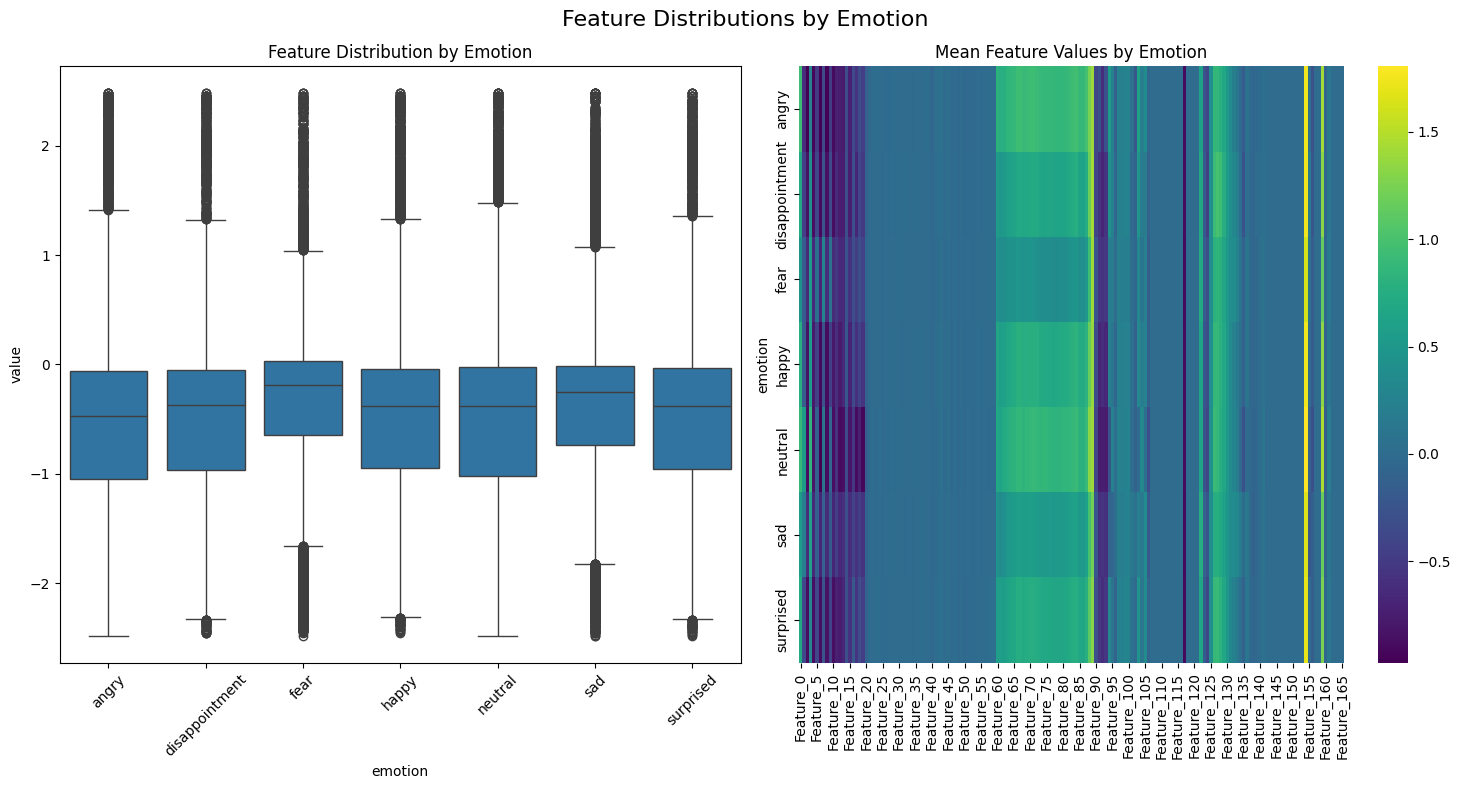


Top 10 Discriminative Features per Emotion:

NEUTRAL:
  Feature_1: 0.8032 (higher than average)
  Feature_94: 0.5068 (higher than average)
  Feature_19: 0.4181 (higher than average)
  Feature_3: 0.4086 (higher than average)
  Feature_103: 0.4074 (higher than average)
  Feature_18: 0.3514 (higher than average)
  Feature_17: 0.3173 (higher than average)
  Feature_7: 0.2568 (higher than average)
  Feature_105: 0.2522 (higher than average)
  Feature_9: 0.2459 (higher than average)

ANGRY:
  Feature_1: 0.5649 (higher than average)
  Feature_94: 0.4142 (higher than average)
  Feature_91: 0.3160 (higher than average)
  Feature_93: 0.3160 (higher than average)
  Feature_103: 0.3062 (higher than average)
  Feature_3: 0.2903 (higher than average)
  Feature_87: 0.2613 (higher than average)
  Feature_7: 0.2568 (higher than average)
  Feature_0: 0.2548 (higher than average)
  Feature_61: 0.2535 (higher than average)

SAD:
  Feature_1: 0.4184 (higher than average)
  Feature_94: 0.3415 (higher than 

  File "d:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "d:\Anaconda\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "d:\Anaconda\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\Anaconda\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


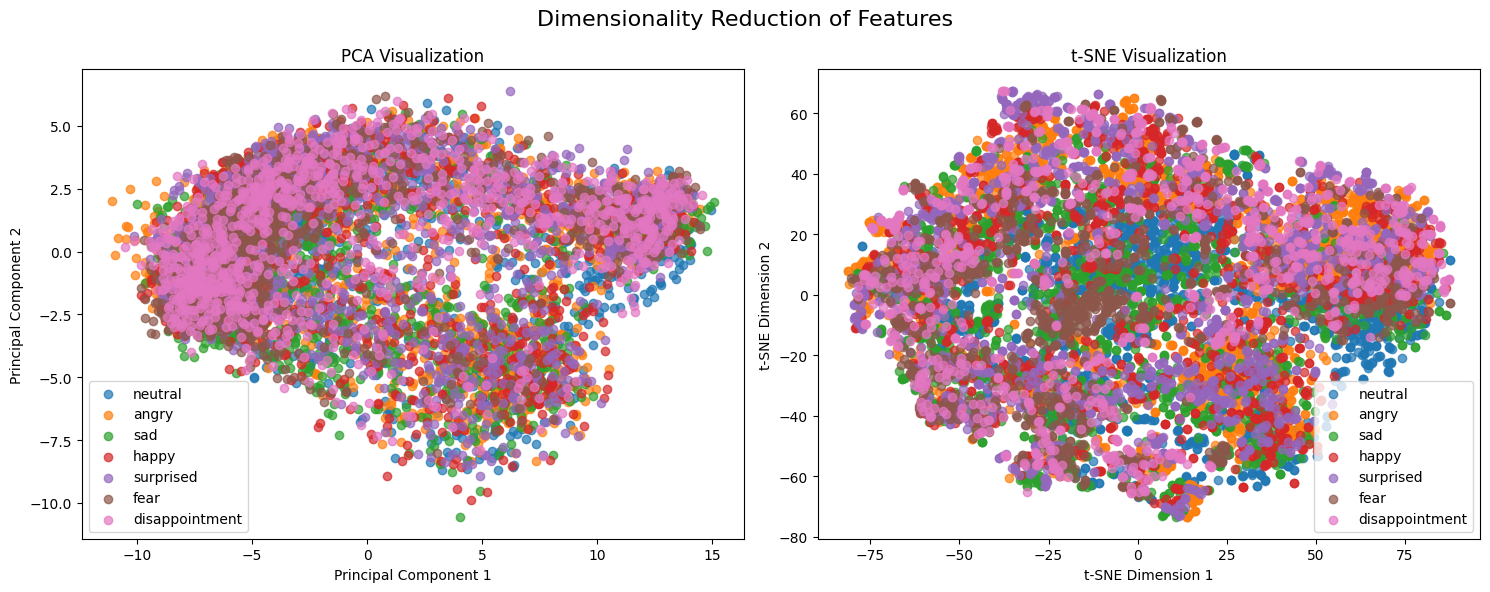

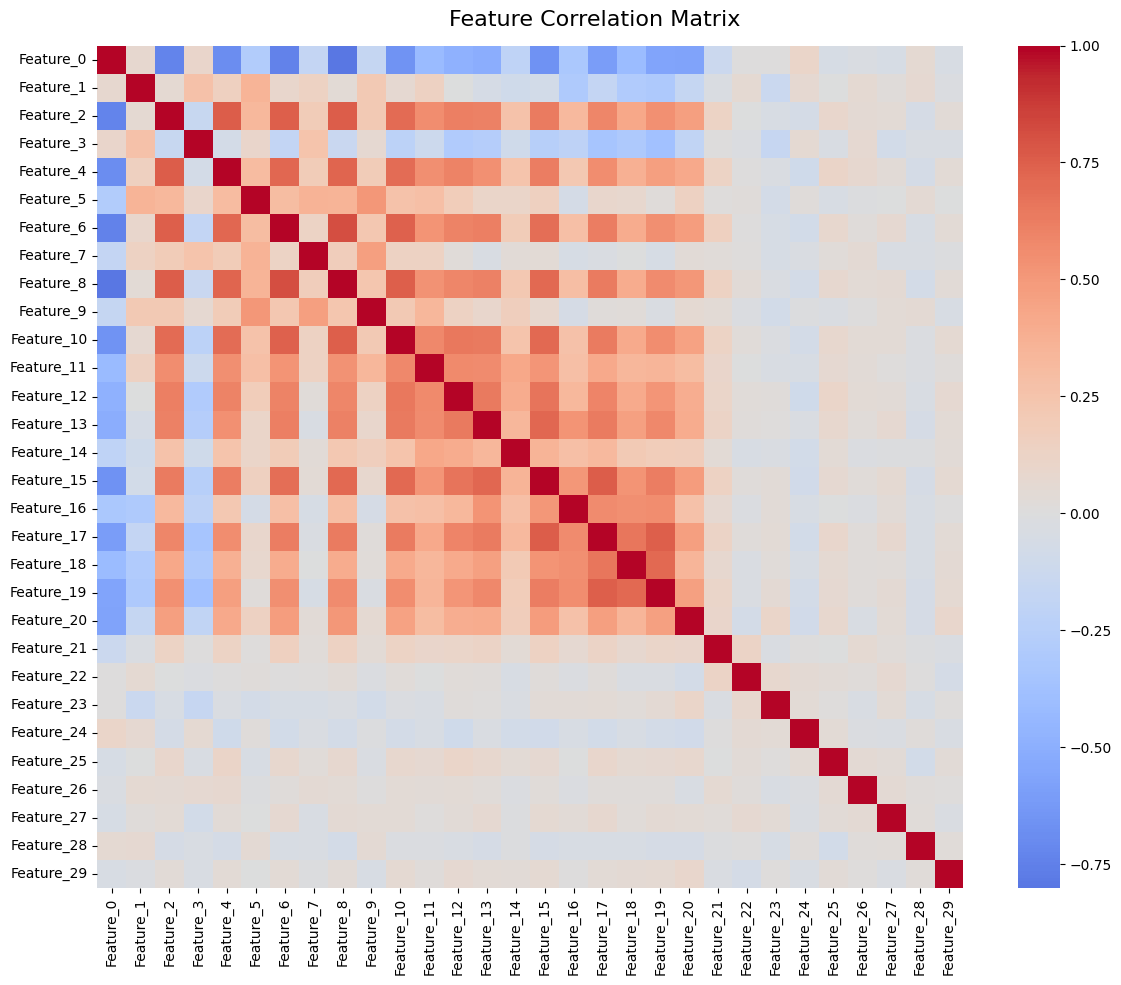


Analyzing Feature Groups:


<Figure size 1400x800 with 0 Axes>

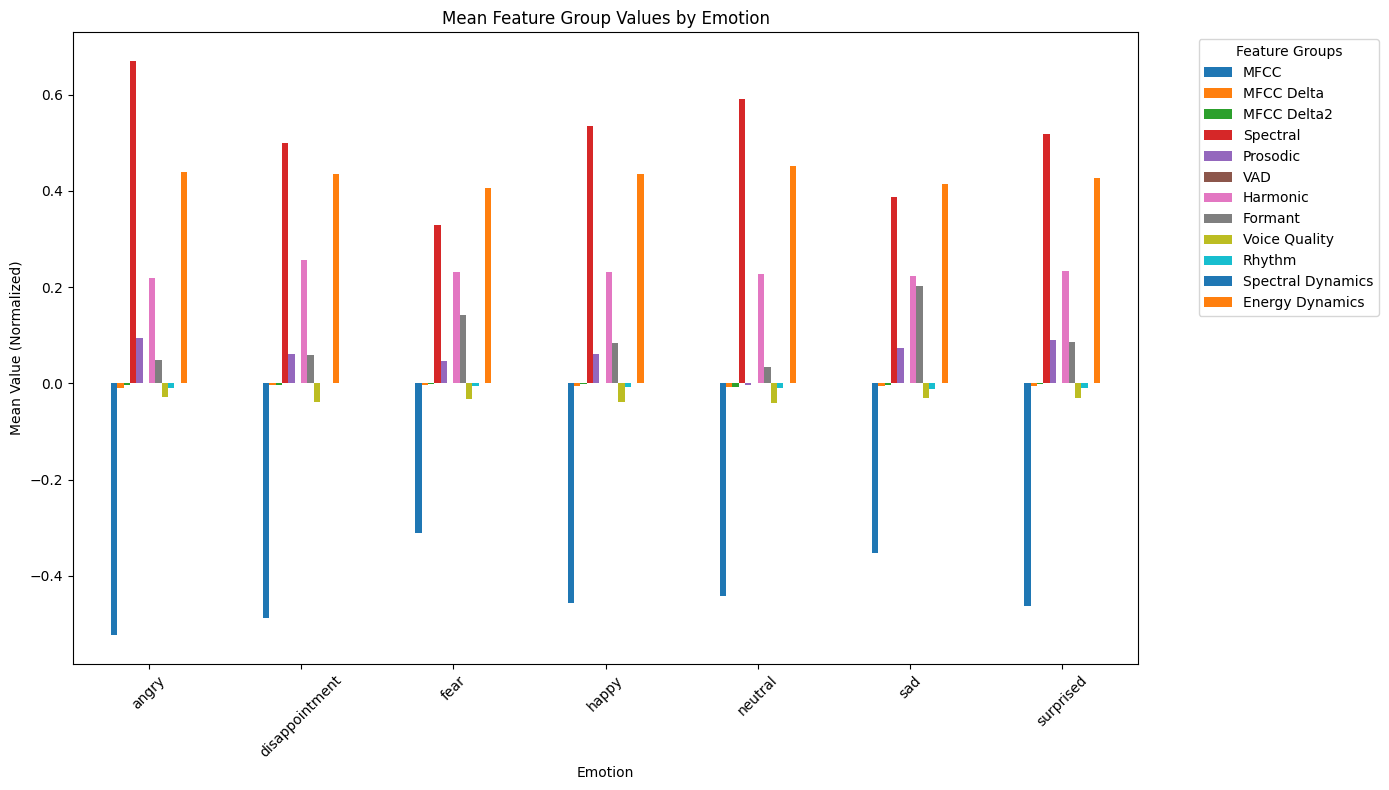


Most Discriminative Feature Groups per Emotion:

NEUTRAL:
  Spectral: 0.0874 (higher than average)
  Prosodic: 0.0637 (higher than average)
  Formant: 0.0590 (higher than average)

ANGRY:
  Spectral: 0.1656 (higher than average)
  MFCC: 0.0890 (higher than average)
  Formant: 0.0454 (higher than average)

SAD:
  Spectral: 0.1162 (higher than average)
  Formant: 0.1091 (higher than average)
  MFCC: 0.0814 (higher than average)

HAPPY:
  Spectral: 0.0300 (higher than average)
  MFCC: 0.0226 (higher than average)
  Formant: 0.0099 (higher than average)

SURPRISED:
  Prosodic: 0.0301 (higher than average)
  MFCC: 0.0296 (higher than average)
  Spectral: 0.0131 (higher than average)

FEAR:
  Spectral: 0.1747 (higher than average)
  MFCC: 0.1218 (higher than average)
  Formant: 0.0481 (higher than average)

DISAPPOINTMENT:
  MFCC: 0.0545 (higher than average)
  Formant: 0.0341 (higher than average)
  Harmonic: 0.0251 (higher than average)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

def visualize_features_per_emotion(all_features, labels, label_map, n_features_to_show=20):
    """
    Visualize the comprehensive features per emotion using multiple visualization techniques
    
    Args:
        all_features: List of feature arrays (each of shape [155, n_frames])
        labels: List of emotion labels for each sample
        label_map: Dictionary mapping emotion names to indices
        n_features_to_show: Number of top features to show in detailed plots
    """
    # Convert labels to indices
    label_indices = [label_map[emotion.lower()] for emotion in labels]
    emotions = list(label_map.keys())
    
    # Aggregate features per sample (mean across frames)
    aggregated_features = []
    for feat in all_features:
        # Take mean across time frames for each feature
        sample_mean = np.mean(feat, axis=1)
        aggregated_features.append(sample_mean)
    
    aggregated_features = np.array(aggregated_features)  # Shape: [n_samples, 155]
    
    # Create a DataFrame for easier manipulation
    feature_names = [f"Feature_{i}" for i in range(aggregated_features.shape[1])]
    df = pd.DataFrame(aggregated_features, columns=feature_names)
    df['emotion'] = [emotions[idx] for idx in label_indices]
    
    # 1. Overall feature distribution per emotion (Boxplot)
    plt.figure(figsize=(15, 8))
    plt.suptitle('Feature Distributions by Emotion', fontsize=16)
    
    # Select a subset of features for visualization
    selected_features = feature_names[:n_features_to_show]
    
    # Melt dataframe for seaborn
    df_melt = pd.melt(df, id_vars=['emotion'], value_vars=selected_features, 
                      var_name='feature', value_name='value')
    
    # Create boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='emotion', y='value', data=df_melt)
    plt.title('Feature Distribution by Emotion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 2. Mean feature values per emotion (Heatmap)
    plt.subplot(1, 2, 2)
    emotion_means = df.groupby('emotion').mean()
    sns.heatmap(emotion_means, cmap='viridis')
    plt.title('Mean Feature Values by Emotion')
    plt.tight_layout()
    
    plt.show()
    
    # 3. Top discriminative features per emotion
    print("\nTop 10 Discriminative Features per Emotion:")
    print("=" * 60)
    
    for emotion in emotions:
        # Get samples for this emotion
        emotion_data = df[df['emotion'] == emotion].drop('emotion', axis=1)
        other_data = df[df['emotion'] != emotion].drop('emotion', axis=1)
        
        # Calculate mean difference between this emotion and others
        emotion_mean = emotion_data.mean()
        other_mean = other_data.mean()
        mean_diff = emotion_mean - other_mean
        
        # Get top features with largest differences
        top_features = mean_diff.abs().sort_values(ascending=False).head(10)
        
        print(f"\n{emotion.upper()}:")
        for feature, diff in top_features.items():
            direction = "higher" if diff > 0 else "lower"
            print(f"  {feature}: {diff:.4f} ({direction} than average)")
    
    # 4. Dimensionality reduction visualization
    print("\nGenerating dimensionality reduction plots...")
    
    # Standardize features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(aggregated_features)
    
    # PCA visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(15, 6))
    plt.suptitle('Dimensionality Reduction of Features', fontsize=16)
    
    plt.subplot(1, 2, 1)
    for emotion in emotions:
        idx = [i for i, e in enumerate(df['emotion']) if e == emotion]
        plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=emotion, alpha=0.7)
    
    plt.title('PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    
    # t-SNE visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result = tsne.fit_transform(features_scaled)
    
    plt.subplot(1, 2, 2)
    for emotion in emotions:
        idx = [i for i, e in enumerate(df['emotion']) if e == emotion]
        plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=emotion, alpha=0.7)
    
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 5. Feature correlation heatmap
    plt.figure(figsize=(12, 10))
    plt.suptitle('Feature Correlation Matrix', fontsize=16)
    
    # Calculate correlation matrix for a subset of features
    corr_features = feature_names[:30]  # First 30 features
    corr_matrix = df[corr_features].corr()
    
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.tight_layout()
    plt.show()
    
    # 6. Feature group analysis
    print("\nAnalyzing Feature Groups:")
    print("=" * 60)
    
    # Define feature groups based on your extraction function
    feature_groups = {
        'MFCC': list(range(0, 20)),  # First 20 features: MFCCs
        'MFCC Delta': list(range(20, 40)),  # Next 20: MFCC deltas
        'MFCC Delta2': list(range(40, 60)),  # Next 20: MFCC delta2
        'Spectral': list(range(60, 101)),  # Spectral features (41 features)
        'Prosodic': list(range(101, 111)),  # Prosodic features (10 features)
        'VAD': list(range(111, 116)),  # VAD features (5 features)
        'Harmonic': list(range(116, 132)),  # Harmonic features (16 features)
        'Formant': list(range(132, 137)),  # Formant features (5 features)
        'Voice Quality': [137],  # HNR feature
        'Rhythm': list(range(138, 143)),  # Rhythm features (5 features)
        'Spectral Dynamics': list(range(143, 151)),  # Spectral dynamics (8 features)
        'Energy Dynamics': list(range(151, 155))  # Energy dynamics (4 features)
    }
    
    # Calculate mean value per group per emotion
    group_means = {}
    for group, indices in feature_groups.items():
        group_features = [feature_names[i] for i in indices if i < len(feature_names)]
        if group_features:
            group_data = df.groupby('emotion')[group_features].mean()
            group_means[group] = group_data.mean(axis=1)  # Mean across features in the group
    
    # Convert to DataFrame for easier plotting
    group_df = pd.DataFrame(group_means)
    
    # Plot feature group means
    plt.figure(figsize=(14, 8))
    group_df.plot(kind='bar', figsize=(14, 8))
    plt.title('Mean Feature Group Values by Emotion')
    plt.ylabel('Mean Value (Normalized)')
    plt.xlabel('Emotion')
    plt.xticks(rotation=45)
    plt.legend(title='Feature Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Print most discriminative feature groups per emotion
    print("\nMost Discriminative Feature Groups per Emotion:")
    for emotion in emotions:
        emotion_values = group_df.loc[emotion]
        overall_mean = group_df.mean()
        diff = emotion_values - overall_mean
        top_groups = diff.abs().sort_values(ascending=False).head(3)
        
        print(f"\n{emotion.upper()}:")
        for group, diff_val in top_groups.items():
            direction = "higher" if diff_val > 0 else "lower"
            print(f"  {group}: {diff_val:.4f} ({direction} than average)")

# After extracting features and creating label_map, call the visualization function
print("\nVisualizing features per emotion...")
visualize_features_per_emotion(all_features, augmented_labels, label_map, n_features_to_show=20)

# Splitting 70:15:15

In [13]:
dataset = SUBESCODataset(all_features, augmented_labels, label_map)
print(f"Total dataset size: {len(dataset)}")

# Step 5: Split dataset
numerical_labels = [label_map[label] for label in augmented_labels]

# Train(70%) / Val(15%) / Test(15%) split
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(sss1.split(np.zeros(len(dataset)), numerical_labels))

train_val_labels = [numerical_labels[i] for i in train_val_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  # 15/85
train_idx, val_idx = next(sss2.split(np.zeros(len(train_val_idx)), train_val_labels))

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)  
test_dataset = torch.utils.data.Subset(dataset, test_idx)

print(f"Dataset splits - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Step 6: Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, 
                            num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                        num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                        num_workers=0, pin_memory=True)

Total dataset size: 9256
Dataset splits - Train: 5553, Val: 1851, Test: 1852


Initializing real-time optimized model...
Starting training...
🎯 Training with target gap: 10.0%
📊 Advanced gap control enabled
Epoch  1/15 | Train: 0.219 | Val: 0.305 | Gap: 0.087 | Loss: 1.6572 | Time: 4.2s | LR: 0.000101
  ✓ New best model saved! Val Accuracy: 0.3052 (Gap: 0.087)
Epoch  2/15 | Train: 0.328 | Val: 0.361 | Gap: 0.033 | Loss: 1.5399 | Time: 3.2s | LR: 0.000102
  ✓ New best model saved! Val Accuracy: 0.3614 (Gap: 0.033)
Epoch  3/15 | Train: 0.408 | Val: 0.472 | Gap: 0.064 | Loss: 1.4388 | Time: 4.2s | LR: 0.000106
  ✓ New best model saved! Val Accuracy: 0.4716 (Gap: 0.064)
Epoch  4/15 | Train: 0.465 | Val: 0.509 | Gap: 0.044 | Loss: 1.3454 | Time: 3.2s | LR: 0.000110
  ✓ New best model saved! Val Accuracy: 0.5089 (Gap: 0.044)
Epoch  5/15 | Train: 0.521 | Val: 0.568 | Gap: 0.047 | Loss: 1.2716 | Time: 3.0s | LR: 0.000115
  ✓ New best model saved! Val Accuracy: 0.5683 (Gap: 0.047)
Epoch  6/15 | Train: 0.592 | Val: 0.563 | Gap: 0.029 | Loss: 1.2801 | Time: 4.4s | LR: 0.000

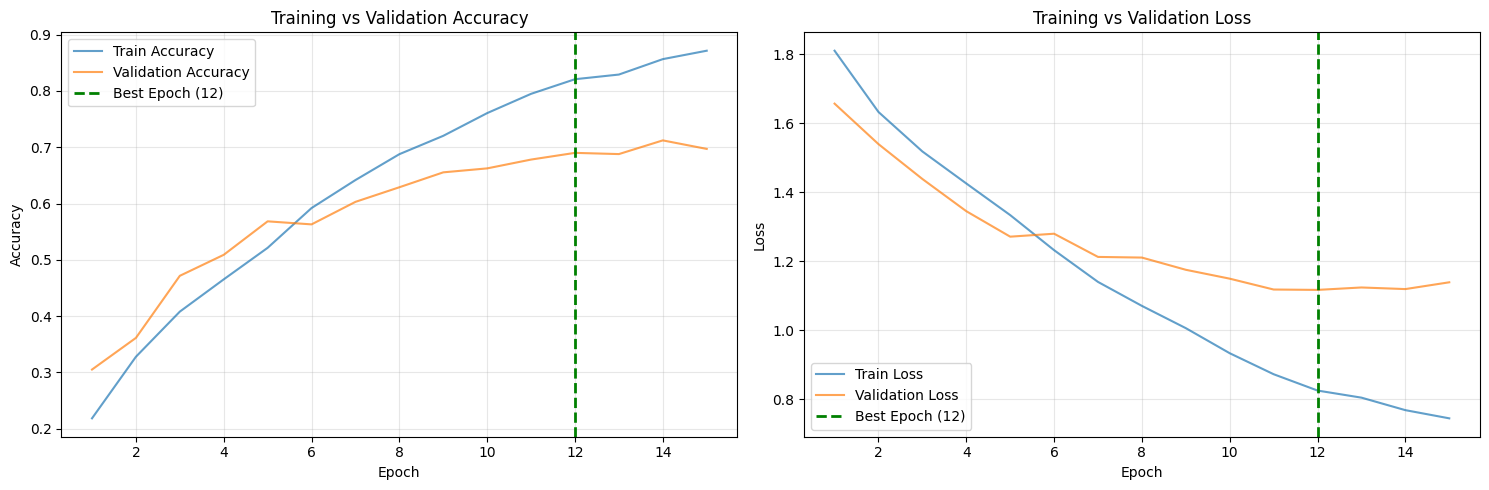

Best epoch: 12
Best validation loss: 1.1173
Best validation accuracy: 0.6899
Final evaluation...
Evaluating model...
Test Accuracy: 0.7694

Classification Report:
                precision    recall  f1-score   support

       neutral       0.78      0.87      0.83       249
         angry       0.79      0.71      0.75       288
           sad       0.83      0.71      0.77       288
         happy       0.82      0.70      0.76       288
     surprised       0.82      0.68      0.74       287
          fear       0.72      0.88      0.80       226
disappointment       0.65      0.88      0.75       226

      accuracy                           0.77      1852
     macro avg       0.77      0.78      0.77      1852
  weighted avg       0.78      0.77      0.77      1852



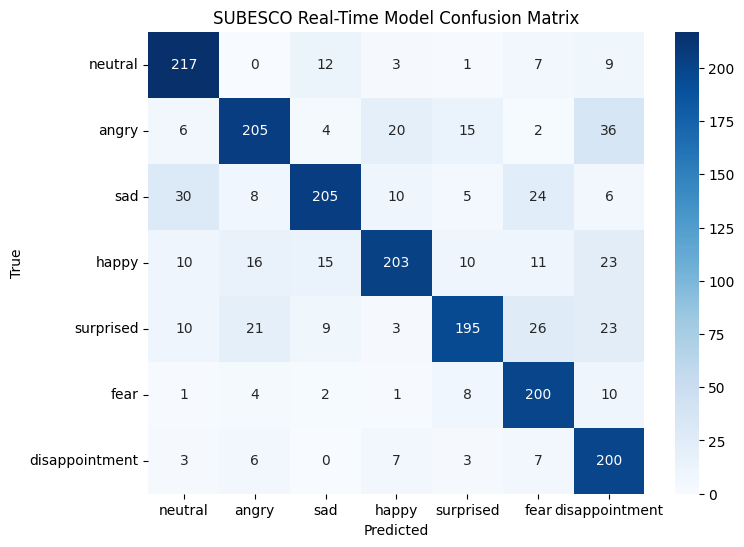


TRAINING COMPLETED!
Final Test Accuracy: 0.7694
Model saved as: SUBESCO_Realtime_Model.pth
Model parameters: 10,260,935


In [14]:
print("Initializing real-time optimized model...")
model = ClassAwareRealtimeCNNTransformer(num_classes=7)
# model = RealTimeSpeechEmotionNet(input_features=166, num_classes=7)

print("Starting training...")
model = train_with_advanced_gap_control(model, train_loader, val_loader, num_epochs=15, target_gap=0.1) # , target_gap=0.1

# Step 8: Evaluate model
print("Final evaluation...")
test_accuracy = evaluate_realtime_model(model, test_loader, label_map_inv)

print(f"\n" + "=" * 60)
print(f"TRAINING COMPLETED!")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Model saved as: SUBESCO_Realtime_Model.pth")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("=" * 60)

Initializing real-time optimized model...
Starting training...
🎯 Training with LR: 0.000040
📊 Gap monitoring threshold: 0.12
Epoch  1/50 | Train: 0.157 | Val: 0.252 | Gap: 0.095 | Loss: 1.8400 | Time: 4.2s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.2518
Epoch  2/50 | Train: 0.250 | Val: 0.278 | Gap: 0.027 | Loss: 1.7279 | Time: 4.1s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.2777
Epoch  3/50 | Train: 0.294 | Val: 0.326 | Gap: 0.033 | Loss: 1.6301 | Time: 3.9s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.3263
Epoch  4/50 | Train: 0.314 | Val: 0.365 | Gap: 0.052 | Loss: 1.5996 | Time: 3.8s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.3652
Epoch  5/50 | Train: 0.349 | Val: 0.425 | Gap: 0.076 | Loss: 1.5180 | Time: 3.8s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.4246
Epoch  6/50 | Train: 0.363 | Val: 0.443 | Gap: 0.080 | Loss: 1.4815 | Time: 3.8s | LR: 0.000040
  ✓ New best model saved! Val Accuracy: 0.4430
Epoch  7/50 | Tra

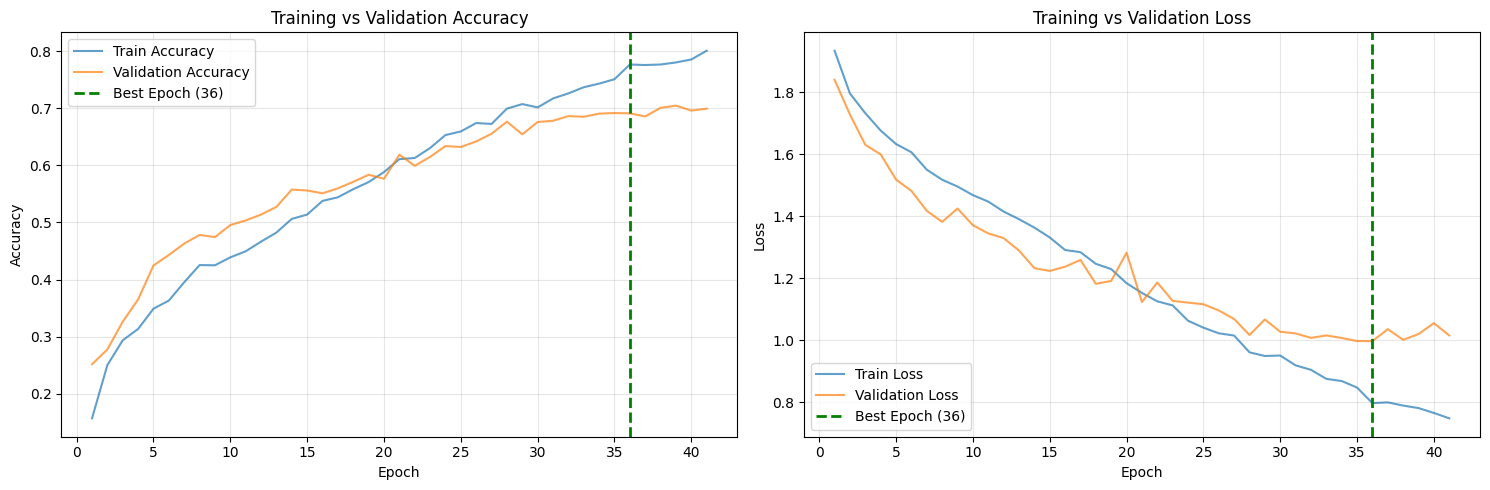

Best epoch: 36
Best validation loss: 0.9967
Best validation accuracy: 0.6910
Training completed! Best validation accuracy: 0.7045
Final evaluation...
Evaluating model...
Test Accuracy: 0.7322

Classification Report:
                precision    recall  f1-score   support

       neutral       0.86      0.80      0.83       249
         angry       0.77      0.69      0.73       288
           sad       0.61      0.77      0.68       288
         happy       0.81      0.68      0.74       288
     surprised       0.79      0.68      0.73       287
          fear       0.71      0.85      0.77       226
disappointment       0.65      0.68      0.67       226

      accuracy                           0.73      1852
     macro avg       0.74      0.74      0.73      1852
  weighted avg       0.74      0.73      0.73      1852



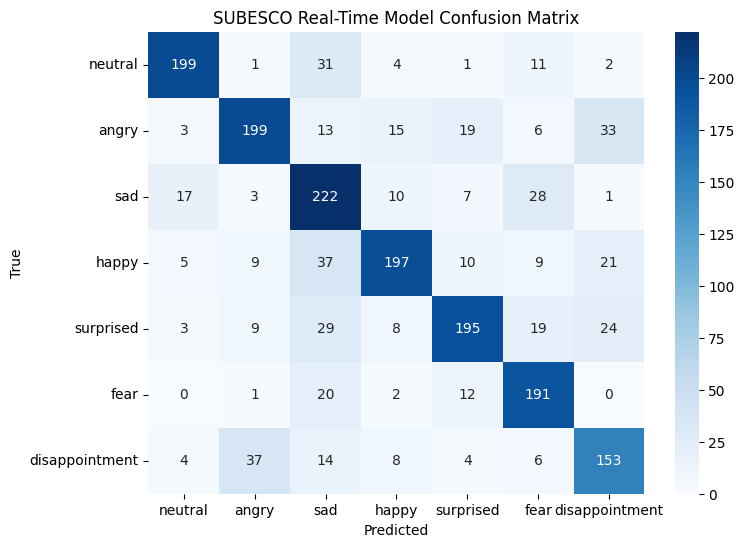


TRAINING COMPLETED!
Final Test Accuracy: 0.7322
Model saved as: Final_MultiScale_Realtime_Model.pth
Model parameters: 7,001,098


In [15]:
print("Initializing real-time optimized model...")
model = MultiScaleCNNTransformer(num_classes=7)
# model = ComprehensiveNoiseRobustModel(num_classes=num_classes)
# model = RealTimeSpeechEmotionNet(input_features=166, num_classes=7)

print("Starting training...")
model = train_best_known_config(model, train_loader, val_loader, num_epochs=50) # , target_gap=0.1

# Step 8: Evaluate model
print("Final evaluation...")
test_accuracy = evaluate_realtime_model(model, test_loader, label_map_inv)

print(f"\n" + "=" * 60)
print(f"TRAINING COMPLETED!")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Model saved as: Final_MultiScale_Realtime_Model.pth")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("=" * 60)

# Seperate Excitement loading drom BanglaMOOD dataset. Takes 15-20 minutes. No cache set up for this.

In [14]:
import os

banglamood_excite_dir = "E:\BanglaMOOD\Excitement"  # Adjust as needed
excite_paths = [os.path.join(banglamood_excite_dir, fname)
                for fname in os.listdir(banglamood_excite_dir)
                if fname.endswith('.wav')]
excite_labels = ["excitement"] * len(excite_paths)

excite_paths, excite_labels = augment_excitement_only(
    excite_paths, 
    excite_labels, 
    target_excitement_count=0
)

# Extract features for excitement samples
excite_features = compute_features_batch(excite_paths)
# Assuming all_features, augmented_labels, augmented_paths already loaded for your main dataset
all_features += excite_features
augmented_labels += excite_labels
augmented_paths += excite_paths


Starting excitement-only augmentation to 0 samples...
Original excitement samples: 257
Other emotion samples: 0
No augmentation needed - already have 257 excitement samples
Computing features for 257 files in 3 batches...
  Processed 0/257 files...
  Processed 200/257 files...
Feature extraction completed!


In [15]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Prepare negative samples
# all_features/augmented_labels: should contain ALL of your dataset, including excitement
neg_features = [f for f, l in zip(all_features, augmented_labels) if str(l).lower() != 'excitement']
neg_labels = [0] * len(neg_features)
neg_N = min(len(neg_features), len(excite_features) * 2) # Use up to 2x the number of positives
np.random.seed(42)
neg_selected_idx = np.random.choice(len(neg_features), size=neg_N, replace=False)
neg_features_balanced = [neg_features[i] for i in neg_selected_idx]
neg_labels_balanced = [0] * len(neg_features_balanced)

# 2. Prepare positive samples
pos_features = list(excite_features)
pos_labels = [1] * len(pos_features)

# 3. Combine & flatten (if features are [features, frames], collapse to mean over frames)
def flatten(feat):
    return np.mean(feat, axis=1) if isinstance(feat, np.ndarray) and feat.ndim == 2 else feat

X = [flatten(f) for f in pos_features + neg_features_balanced]
y = pos_labels + neg_labels_balanced

# 4. Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 5. PyTorch Dataset and DataLoader
class ExciteBinaryDataset(Dataset):
    def __init__(self, X, y):
        self.X = [torch.tensor(f, dtype=torch.float32) for f in X]
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

batch_size = 32
train_ds, val_ds, test_ds = [ExciteBinaryDataset(a, b) for a, b in [(X_train, y_train), (X_val, y_val), (X_test, y_test)]]
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random

# ======================= CORRECTED STRICT EXCITEMENT MODEL =======================

class StrictExcitementDetector(nn.Module):
    def __init__(self, input_dim, embedding_dim=24):
        super().__init__()
        
        # Ultra-focused encoder for excitement-specific patterns
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 96),
            nn.LayerNorm(96),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(96, 48),
            nn.LayerNorm(48),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(48, embedding_dim)
        )
        
        # Excitement confidence scorer
        self.excitement_scorer = nn.Sequential(
            nn.Linear(embedding_dim, 12),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(12, 1),
            nn.Sigmoid()
        )
        
        # Fixed threshold as requested
        self.threshold = 0.5
        
    def forward(self, x):
        embeddings = self.encoder(x)
        excitement_score = self.excitement_scorer(embeddings)
        return embeddings, excitement_score
    
    def get_excitement_score(self, x):
        with torch.no_grad():
            _, score = self.forward(x)
            return score.squeeze()
    
    def predict_excitement(self, x):
        score = self.get_excitement_score(x)
        return (score > self.threshold).float(), score

# ======================= CORRECTED LOSS FUNCTION =======================

class StrictExcitementLoss(nn.Module):
    def __init__(self, margin=2.0, strict_penalty=5.0):
        super().__init__()
        self.triplet_loss = nn.TripletMarginLoss(margin=margin)
        self.bce_loss = nn.BCELoss()
        self.strict_penalty = strict_penalty
        
    def compute_classification_loss(self, excitement_scores, labels):
        """Compute classification loss with strict penalties"""
        if excitement_scores is None:
            raise ValueError("excitement_scores cannot be None")
            
        # Base classification loss
        classification_loss = self.bce_loss(excitement_scores.squeeze(), labels.float())
        
        # STRICT penalty for ANY false positive
        false_positive_penalty = 0.0
        for score, label in zip(excitement_scores.squeeze(), labels):
            if label == 0 and score > 0.3:  # Any non-excitement predicted > 0.3
                false_positive_penalty += self.strict_penalty * score
        
        false_positive_penalty = false_positive_penalty / len(labels) if len(labels) > 0 else 0
        
        # Encourage high confidence for true excitement
        true_excitement_boost = 0.0
        for score, label in zip(excitement_scores.squeeze(), labels):
            if label == 1 and score < 0.7:  # Excitement should be > 0.7
                true_excitement_boost += (0.7 - score)
        
        true_excitement_boost = true_excitement_boost / len(labels) if len(labels) > 0 else 0
        
        total_loss = classification_loss + false_positive_penalty + true_excitement_boost
        
        return total_loss, classification_loss.item(), false_positive_penalty, true_excitement_boost
    
    def compute_triplet_loss(self, anchor_emb, pos_emb, neg_emb):
        """Compute triplet loss for better separation"""
        if anchor_emb is None or pos_emb is None or neg_emb is None:
            return torch.tensor(0.0, requires_grad=True)
        
        return self.triplet_loss(anchor_emb, pos_emb, neg_emb)

# ======================= CORRECTED DATASET CLASS =======================

def flatten(feat):
    """Flatten features for model input"""
    return np.mean(feat, axis=1) if isinstance(feat, np.ndarray) and feat.ndim == 2 else feat

def create_all_emotion_negatives():
    """Create negatives from ALL other emotions"""
    
    print("📊 CREATING ALL-EMOTION NEGATIVE DATASET")
    print("="*50)
    
    # Target emotions to reject
    reject_emotions = ['angry', 'happy', 'surprise', 'disappointment', 'neutral', 'fear', 'sad', 'disgust']
    
    all_negatives = []
    emotion_counts = {}
    
    for f, l in zip(all_features, augmented_labels):
        label_str = str(l).lower()
        if 'excitement' not in label_str:
            # Check if it matches any emotion we want to reject
            matched_emotion = None
            for emotion in reject_emotions:
                if emotion in label_str:
                    matched_emotion = emotion
                    break
            
            if matched_emotion:
                all_negatives.append(flatten(f))
                emotion_counts[matched_emotion] = emotion_counts.get(matched_emotion, 0) + 1
    
    print("Negative emotion distribution:")
    for emotion, count in emotion_counts.items():
        print(f"  {emotion}: {count} samples")
    
    # Balance negatives - use 3x excitement samples as negatives
    excitement_count = len(pos_features)
    target_negatives = excitement_count * 3
    
    if len(all_negatives) > target_negatives:
        # Random selection if too many
        selected_indices = np.random.choice(len(all_negatives), target_negatives, replace=False)
        balanced_negatives = [all_negatives[i] for i in selected_indices]
    else:
        # Use all + augment with repetition if too few
        balanced_negatives = all_negatives.copy()
        while len(balanced_negatives) < target_negatives:
            additional_needed = target_negatives - len(balanced_negatives)
            additional_indices = np.random.choice(len(all_negatives), 
                                                min(additional_needed, len(all_negatives)), 
                                                replace=True)
            balanced_negatives.extend([all_negatives[i] for i in additional_indices])
    
    print(f"\nFinal dataset:")
    print(f"  Excitement samples: {excitement_count}")
    print(f"  All-emotion negatives: {len(balanced_negatives)}")
    print(f"  Negative-to-positive ratio: {len(balanced_negatives)/excitement_count:.1f}:1")
    
    return balanced_negatives

class StrictTrainingDataset(Dataset):
    def __init__(self, excitement_features, negative_features):
        # Flatten and convert excitement features
        self.excitement_data = [torch.tensor(flatten(f), dtype=torch.float32) for f in excitement_features]
        self.negative_data = [torch.tensor(f, dtype=torch.float32) for f in negative_features]
        
        # Create triplets for contrastive learning
        self.triplets = []
        self._create_triplets()
        
        # Combine all data for regular training
        self.all_features = self.excitement_data + self.negative_data
        self.all_labels = [1] * len(self.excitement_data) + [0] * len(self.negative_data)
        
    def _create_triplets(self):
        """Create triplets: (excitement_anchor, excitement_positive, any_negative)"""
        
        if len(self.excitement_data) < 2:
            return
        
        # Create many triplets for strong contrastive learning
        n_triplets = min(len(self.excitement_data) * 5, 2000)
        
        for _ in range(n_triplets):
            # Anchor: excitement sample
            anchor_idx = random.randint(0, len(self.excitement_data) - 1)
            anchor = self.excitement_data[anchor_idx]
            
            # Positive: different excitement sample  
            pos_idx = random.randint(0, len(self.excitement_data) - 1)
            while pos_idx == anchor_idx and len(self.excitement_data) > 1:
                pos_idx = random.randint(0, len(self.excitement_data) - 1)
            positive = self.excitement_data[pos_idx]
            
            # Negative: any non-excitement emotion
            if self.negative_data:
                neg_idx = random.randint(0, len(self.negative_data) - 1)
                negative = self.negative_data[neg_idx]
                self.triplets.append((anchor, positive, negative))
        
        print(f"Created {len(self.triplets)} triplets for strict contrastive learning")
    
    def __len__(self):
        return len(self.all_features)
    
    def __getitem__(self, idx):
        return self.all_features[idx], self.all_labels[idx]
    
    def get_triplet_batch(self, batch_size=12):
        """Get a batch of triplets"""
        if not self.triplets:
            return None
        
        triplet_indices = random.sample(range(len(self.triplets)), min(batch_size, len(self.triplets)))
        batch_triplets = [self.triplets[i] for i in triplet_indices]
        
        anchors = torch.stack([t[0] for t in batch_triplets])
        positives = torch.stack([t[1] for t in batch_triplets])
        negatives = torch.stack([t[2] for t in batch_triplets])
        
        return anchors, positives, negatives


In [16]:
# ======================= CORRECTED TRAINING FUNCTION =======================

def train_strict_excitement_detector():
    """Train ultra-strict excitement-only detector with fixed loss calculation"""
    
    print("🎯 TRAINING STRICT EXCITEMENT-ONLY DETECTOR")
    print("="*70)
    print("REJECTING: angry, happy, surprised, disappointment, neutral, fear, sad")
    print("ACCEPTING: Only pure excitement")
    print("THRESHOLD: Fixed at 0.5")
    print("="*70)
    
    # Prepare strict dataset
    excitement_features = list(pos_features)
    all_negative_features = create_all_emotion_negatives()
    
    # Create strict training dataset
    strict_dataset = StrictTrainingDataset(excitement_features, all_negative_features)
    
    # Train/validation split
    train_size = int(0.85 * len(strict_dataset))
    val_size = len(strict_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(strict_dataset, [train_size, val_size])
    
    # Data loaders with smaller batches for stability
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=16, drop_last=True)
    
    # Initialize model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    input_dim = len(flatten(excitement_features[0]))
    model = StrictExcitementDetector(input_dim=input_dim, embedding_dim=24).to(device)
    
    # Strict loss function and optimizer
    criterion = StrictExcitementLoss(margin=2.5, strict_penalty=8.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=2e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.3)
    
    print(f"Model input dimension: {input_dim}")
    print(f"Training samples: {train_size}")
    print(f"Validation samples: {val_size}")
    print(f"Using device: {device}")
    
    # Training loop
    best_val_precision = 0.0
    patience_counter = 0
    patience = 15
    
    for epoch in range(100):
        model.train()
        total_loss = 0.0
        class_loss_sum = 0.0
        fp_penalty_sum = 0.0
        boost_sum = 0.0
        triplet_loss_sum = 0.0
        correct = 0
        total_samples = 0
        
        for batch_idx, (features, labels) in enumerate(train_loader):
            features = features.to(device)
            labels = torch.tensor(labels, dtype=torch.float32).to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            embeddings, excitement_scores = model(features)
            
            # Classification loss (always computed)
            class_loss, class_loss_val, fp_penalty, boost = criterion.compute_classification_loss(
                excitement_scores, labels
            )
            
            total_batch_loss = class_loss
            
            # Add triplet loss every few batches for stronger separation
            triplet_loss_val = 0.0
            if batch_idx % 2 == 0:  # Every other batch
                triplet_batch = strict_dataset.get_triplet_batch(batch_size=12)
                if triplet_batch is not None:
                    anchors, positives, negatives = triplet_batch
                    anchors = anchors.to(device)
                    positives = positives.to(device) 
                    negatives = negatives.to(device)
                    
                    # Get embeddings for triplets
                    anchor_emb, _ = model(anchors)
                    pos_emb, _ = model(positives)
                    neg_emb, _ = model(negatives)
                    
                    # Compute triplet loss
                    triplet_loss = criterion.compute_triplet_loss(anchor_emb, pos_emb, neg_emb)
                    triplet_loss_val = triplet_loss.item()
                    total_batch_loss += 0.8 * triplet_loss  # Strong triplet weight
            
            total_batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            
            # Accumulate metrics
            total_loss += total_batch_loss.item()
            class_loss_sum += class_loss_val
            fp_penalty_sum += fp_penalty
            boost_sum += boost
            triplet_loss_sum += triplet_loss_val
            
            # Calculate accuracy
            with torch.no_grad():
                pred = (excitement_scores.squeeze() > 0.5).float()
                correct += (pred == labels).sum().item()
                total_samples += len(labels)
        
        # Calculate epoch metrics
        avg_loss = total_loss / len(train_loader)
        train_acc = correct / total_samples
        
        # Validation with focus on precision
        model.eval()
        val_true_positives = 0
        val_false_positives = 0
        val_false_negatives = 0
        val_true_negatives = 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = torch.tensor(labels, dtype=torch.float32).to(device)
                
                scores = model.get_excitement_score(features)
                predictions = (scores > 0.5).float()
                
                for pred, true_label in zip(predictions, labels):
                    if pred == 1 and true_label == 1:
                        val_true_positives += 1
                    elif pred == 1 and true_label == 0:
                        val_false_positives += 1
                    elif pred == 0 and true_label == 1:
                        val_false_negatives += 1
                    else:
                        val_true_negatives += 1
        
        # Calculate precision, recall, F1
        precision = val_true_positives / (val_true_positives + val_false_positives) if (val_true_positives + val_false_positives) > 0 else 0
        recall = val_true_positives / (val_true_positives + val_false_negatives) if (val_true_positives + val_false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Print epoch results
        print(f"Epoch {epoch+1:03d} | "
              f"Loss: {avg_loss:.4f} | "
              f"Class: {class_loss_sum/len(train_loader):.4f} | "
              f"Triplet: {triplet_loss_sum/len(train_loader):.4f}")
        print(f"           | "
              f"Train Acc: {train_acc:.3f} | "
              f"Val Precision: {precision:.3f} | "
              f"Val Recall: {recall:.3f} | "
              f"F1: {f1:.3f}")
        print(f"           | "
              f"TP: {val_true_positives} | "
              f"FP: {val_false_positives} | "
              f"FN: {val_false_negatives} | "
              f"TN: {val_true_negatives}")
        
        # Learning rate scheduling
        scheduler.step(precision)
        
        # Early stopping based on precision
        if precision > best_val_precision and precision > 0.8:
            best_val_precision = precision
            patience_counter = 0
            
            # Save best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'threshold': 0.5,
                'input_dim': input_dim,
                'best_precision': best_val_precision,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'epoch': epoch + 1
            }, 'strict_excitement_detector.pth')
            
            print(f"           | ✅ New best model saved! (Precision: {best_val_precision:.3f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {epoch + 1} epochs")
                break
    
    # Load best model
    if os.path.exists('strict_excitement_detector.pth'):
        checkpoint = torch.load('strict_excitement_detector.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        model.threshold = 0.5
        
        print(f"\n🎉 STRICT TRAINING COMPLETED!")
        print(f"Best validation precision: {checkpoint['best_precision']:.3f}")
        print(f"Best recall: {checkpoint['recall']:.3f}")
        print(f"Best F1: {checkpoint['f1']:.3f}")
        print(f"Model threshold: {model.threshold}")
        print(f"Model saved as: 'strict_excitement_detector.pth'")
    
    return model

def save_strict_model(model, filename='final_strict_excitement_detector.pth'):
    """Save the final strict model"""
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'threshold': 0.5,
        'input_dim': len(flatten(pos_features[0])) if pos_features else None,
        'model_type': 'StrictExcitementDetector',
        'rejected_emotions': ['angry', 'happy', 'surprised', 'disappointment', 'neutral', 'fear', 'sad'],
        'training_approach': 'Ultra-strict with high false-positive penalty',
        'designed_for': 'Pure excitement detection only'
    }, filename)
    
    print(f"✅ Strict model saved as '{filename}'")

In [18]:
# ======================= MAIN EXECUTION =======================

if __name__ == "__main__":
    print("🔥 ULTRA-STRICT EXCITEMENT-ONLY TRAINING (FIXED)")
    print("="*60)
    print("🎯 Target: Ignore ALL other emotions")
    print("🚫 Rejecting: angry, happy, surprised, disappointment, neutral, fear, sad")
    print("✅ Accepting: Only pure excitement")
    print("⚖️  Threshold: Fixed at 0.5")
    print("🔧 Fix: Proper loss function parameter handling")
    print("="*60)
    
    try:
        # Train the strict model
        strict_model = train_strict_excitement_detector()
        
        # Save final model
        save_strict_model(strict_model, 'final_strict_excitement_detector.pth')
        
        print("\n🚀 SUCCESS! Ultra-strict excitement detector trained.")
        print("   This model will be extremely conservative - only predicting excitement when very confident.")
        print("   Threshold is fixed at 0.5 as requested.")
        
    except Exception as e:
        print(f"❌ Training failed: {e}")
        import traceback
        traceback.print_exc()

🔥 ULTRA-STRICT EXCITEMENT-ONLY TRAINING (FIXED)
🎯 Target: Ignore ALL other emotions
🚫 Rejecting: angry, happy, surprised, disappointment, neutral, fear, sad
✅ Accepting: Only pure excitement
⚖️  Threshold: Fixed at 0.5
🔧 Fix: Proper loss function parameter handling
🎯 TRAINING STRICT EXCITEMENT-ONLY DETECTOR
REJECTING: angry, happy, surprised, disappointment, neutral, fear, sad
ACCEPTING: Only pure excitement
THRESHOLD: Fixed at 0.5
📊 CREATING ALL-EMOTION NEGATIVE DATASET
Negative emotion distribution:
  angry: 1438 samples
  disappointment: 1132 samples
  fear: 1132 samples
  happy: 1438 samples
  neutral: 1243 samples
  sad: 1438 samples
  surprise: 1435 samples

Final dataset:
  Excitement samples: 257
  All-emotion negatives: 771
  Negative-to-positive ratio: 3.0:1
Created 1285 triplets for strict contrastive learning
Model input dimension: 166
Training samples: 873
Validation samples: 155
Using device: cuda
Epoch 001 | Loss: 3.3094 | Class: 0.5791 | Triplet: 1.0903
           | Tra

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import librosa
import pyaudio
import wave
import time
from datetime import datetime

# Re-define the StrictExcitementDetector class for loading
class StrictExcitementDetector(nn.Module):
    def __init__(self, input_dim, embedding_dim=24):
        super().__init__()
        
        # Ultra-focused encoder for excitement-specific patterns
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 96),
            nn.LayerNorm(96),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(96, 48),
            nn.LayerNorm(48),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(48, embedding_dim)
        )
        
        # Excitement confidence scorer
        self.excitement_scorer = nn.Sequential(
            nn.Linear(embedding_dim, 12),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(12, 1),
            nn.Sigmoid()
        )
        
        # Fixed threshold as requested
        self.threshold = 0.5
        
    def forward(self, x):
        embeddings = self.encoder(x)
        excitement_score = self.excitement_scorer(embeddings)
        return embeddings, excitement_score
    
    def get_excitement_score(self, x):
        with torch.no_grad():
            _, score = self.forward(x)
            return score.squeeze()
    
    def predict_excitement(self, x):
        score = self.get_excitement_score(x)
        return (score > self.threshold).float(), score

def flatten(feat):
    """Flatten features for model input"""
    return np.mean(feat, axis=1) if isinstance(feat, np.ndarray) and feat.ndim == 2 else feat

def load_strict_model(filename='strict_excitement_detector.pth', input_dim=None):
    """Load the trained strict excitement detector"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    try:
        # Try loading with safe globals first
        checkpoint = torch.load(filename, map_location=device, weights_only=False)
        print(f"✅ Model loaded successfully")
        
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        return None
    
    # Extract model parameters
    if input_dim is None:
        input_dim = checkpoint.get('input_dim', 166)
    
    # Create and load model
    model = StrictExcitementDetector(input_dim=input_dim).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.threshold = 0.5  # Always use 0.5 as requested
    
    print(f"   Model type: Strict Excitement Detector")
    print(f"   Input dimension: {input_dim}")
    print(f"   Threshold: {model.threshold}")
    print(f"   Rejected emotions: angry, happy, surprised, disappointment, neutral, fear, sad")
    
    return model

def record_microphone_audio(duration=3, sample_rate=22050, filename=None):
    """Record audio from microphone for specified duration"""
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"mic_recording_{timestamp}.wav"
    
    # Audio recording parameters
    chunk = 1024
    channels = 1
    
    # Initialize PyAudio
    audio = pyaudio.PyAudio()
    
    print(f"🎤 Recording from microphone for {duration} seconds...")
    print("   Speak with excitement now!")
    
    # Start countdown
    for i in range(duration, 0, -1):
        print(f"   {i}...", end=" ")
        time.sleep(1)
    print("Recording!")
    
    try:
        # Open stream
        stream = audio.open(
            format=pyaudio.paInt16,
            channels=channels,
            rate=sample_rate,
            input=True,
            frames_per_buffer=chunk
        )
        
        frames = []
        
        # Record audio
        for _ in range(0, int(sample_rate / chunk * duration)):
            data = stream.read(chunk)
            frames.append(data)
        
        print("   Recording finished!")
        
        # Close stream
        stream.stop_stream()
        stream.close()
        audio.terminate()
        
        # Save recording
        with wave.open(filename, 'wb') as wf:
            wf.setnchannels(channels)
            wf.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
            wf.setframerate(sample_rate)
            wf.writeframes(b''.join(frames))
        
        print(f"   Audio saved as: {filename}")
        return filename
        
    except Exception as e:
        print(f"   Recording error: {e}")
        audio.terminate()
        return None

def predict_single_audio_strict(model, audio_path, show_details=True):
    """Predict excitement using the strict model (no post-processing needed)"""
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    try:
        # Extract features using your existing function
        features = extract_comprehensive_noise_robust_features(audio_path)
        flattened = flatten(features)
        x_tensor = torch.tensor(flattened, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Get prediction (no post-processing - model is already strict)
        with torch.no_grad():
            prediction, score = model.predict_excitement(x_tensor)
            prediction = prediction.item()
            score = score.item()
        
        if show_details:
            print(f"\n📊 Strict Excitement Prediction for: {os.path.basename(audio_path)}")
            
            if prediction == 1:
                print(f"   🎉 RESULT: **PURE EXCITEMENT DETECTED**")
                print(f"   📈 Confidence Score: {score:.3f}")
                print(f"   ✅ This audio passed the ultra-strict excitement filter")
            else:
                print(f"   😐 RESULT: **NOT EXCITEMENT**")
                print(f"   📉 Score: {score:.3f} (below threshold 0.5)")
                print(f"   🚫 Rejected by strict filter (likely another emotion)")
        
        return {
            'filename': os.path.basename(audio_path),
            'prediction': int(prediction),
            'score': score,
            'is_excitement': prediction == 1
        }
        
    except Exception as e:
        print(f"❌ Error processing {audio_path}: {e}")
        return None

def test_folder_strict(model, folder_path):
    """Test all audio files in folder with strict model"""
    
    print(f"📁 TESTING STRICT EXCITEMENT DETECTOR")
    print(f"="*60)
    print(f"📂 Folder: {folder_path}")
    print(f"🎯 Model: Ultra-strict (ignores ALL other emotions)")
    print(f"⚖️  Threshold: 0.5 (fixed)")
    print("-"*60)
    
    if not os.path.exists(folder_path):
        print(f"   ❌ Folder does not exist: {folder_path}")
        return []
    
    audio_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.wav')]
    
    if not audio_files:
        print("   No .wav files found in the folder!")
        return []
    
    print(f"   Found {len(audio_files)} audio files")
    print()
    
    results = []
    excitement_detected = []
    
    for file_name in audio_files:
        file_path = os.path.join(folder_path, file_name)
        result = predict_single_audio_strict(model, file_path, show_details=False)
        
        if result:
            results.append(result)
            
            if result['is_excitement']:
                excitement_detected.append(file_name)
                print(f"   🎉 {file_name}: **EXCITEMENT** (Score: {result['score']:.3f})")
            else:
                print(f"   😐 {file_name}: Not excitement (Score: {result['score']:.3f})")
    
    # Summary
    total = len(results)
    excitement_count = len(excitement_detected)
    
    print(f"\n📊 STRICT MODEL RESULTS SUMMARY:")
    print(f"="*50)
    print(f"Total files tested: {total}")
    print(f"🎉 **PURE EXCITEMENT DETECTED**: {excitement_count} files ({excitement_count/total*100:.1f}%)")
    print(f"😐 **REJECTED** (other emotions): {total-excitement_count} files ({(total-excitement_count)/total*100:.1f}%)")
    print(f"🎯 Model threshold: 0.5 (ultra-strict)")
    
    if excitement_detected:
        print(f"\n✅ Files classified as PURE EXCITEMENT:")
        for i, filename in enumerate(excitement_detected, 1):
            result = next(r for r in results if r['filename'] == filename)
            print(f"   {i}. {filename} (Score: {result['score']:.3f})")
    else:
        print(f"\n🚫 No files were classified as pure excitement.")
        print(f"   This is expected with the ultra-strict model.")
        print(f"   Try files with very clear, genuine excitement.")
    
    return results

def interactive_microphone_test_strict(model):
    """Interactive microphone testing with strict model"""
    
    print("\n🎤 STRICT EXCITEMENT MICROPHONE TESTING")
    print("="*60)
    print("🎯 This strict model only detects PURE excitement")
    print("🚫 It will reject: angry, happy, surprised, disappointment, neutral, fear, sad")
    print("✅ Speak with genuine excitement to test!")
    print("⚖️  Fixed threshold: 0.5")
    print("-"*60)
    print("Record 3 seconds of audio. Type 'quit' to exit.\n")
    
    test_count = 0
    excitement_detections = 0
    
    while True:
        user_input = input("Press Enter to start recording (or type 'quit' to exit): ").strip().lower()
        
        if user_input == 'quit':
            print(f"\n👋 Testing completed!")
            if test_count > 0:
                print(f"📊 Summary: {excitement_detections}/{test_count} recordings detected as excitement")
                print(f"   Success rate: {excitement_detections/test_count*100:.1f}%")
            break
        
        test_count += 1
        
        # Record audio
        audio_file = record_microphone_audio(duration=3)
        
        if audio_file:
            print(f"\n🔍 Analyzing recording #{test_count}...")
            
            # Predict excitement
            result = predict_single_audio_strict(model, audio_file, show_details=True)
            
            if result and result['is_excitement']:
                excitement_detections += 1
                print(f"   🏆 EXCITEMENT DETECTION COUNT: {excitement_detections}")
            
            # Clean up recording file
            try:
                os.remove(audio_file)
            except:
                pass
        
        print("\n" + "-"*50)

# ======================= MAIN TESTING EXECUTION =======================

print("🔥 STRICT EXCITEMENT DETECTOR TESTING")
print("="*60)
print("🎯 Ultra-Strict Model: Only Pure Excitement")
print("🚫 Rejects: angry, happy, surprised, disappointment, neutral, fear, sad")
print("⚖️  Threshold: 0.5 (fixed)")
print("="*60)

# Load the strict model
try:
    model = load_strict_model('strict_excitement_detector.pth')
    
    if model is None:
        print("❌ Failed to load model!")
    else:
        print("\n🎛️  Choose testing option:")
        print("1️⃣  Test audio files in folder")
        print("2️⃣  Test with microphone recording") 
        print("3️⃣  Both folder and microphone")
        
        choice = input("\nEnter your choice (1, 2, or 3): ").strip()
        
        if choice in ['1', '3']:
            # Test folder files
            folder_path = r"C:\Users\guyaw\Desktop\CSE499 Research papers\Jupiter\7-Emotion-Bangla-Speech-Recognition-Model\Testing"
            
            # Allow user to change folder path if needed
            print(f"\nDefault folder: {folder_path}")
            custom_path = input("Press Enter to use default, or type new path: ").strip()
            if custom_path:
                folder_path = custom_path
            
            results = test_folder_strict(model, folder_path)
        
        if choice in ['2', '3']:
            # Test with microphone
            interactive_microphone_test_strict(model)

except FileNotFoundError:
    print("❌ Model file not found!")
    print("   Expected: 'strict_excitement_detector.pth'")
    print("   Make sure you trained the model first.")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()


🔥 STRICT EXCITEMENT DETECTOR TESTING
🎯 Ultra-Strict Model: Only Pure Excitement
🚫 Rejects: angry, happy, surprised, disappointment, neutral, fear, sad
⚖️  Threshold: 0.5 (fixed)
✅ Model loaded successfully
   Model type: Strict Excitement Detector
   Input dimension: 166
   Threshold: 0.5
   Rejected emotions: angry, happy, surprised, disappointment, neutral, fear, sad

🎛️  Choose testing option:
1️⃣  Test audio files in folder
2️⃣  Test with microphone recording
3️⃣  Both folder and microphone



🎤 STRICT EXCITEMENT MICROPHONE TESTING
🎯 This strict model only detects PURE excitement
🚫 It will reject: angry, happy, surprised, disappointment, neutral, fear, sad
✅ Speak with genuine excitement to test!
⚖️  Fixed threshold: 0.5
------------------------------------------------------------
Record 3 seconds of audio. Type 'quit' to exit.

🎤 Recording from microphone for 3 seconds...
   Speak with excitement now!
   3...    2...    1... Recording!
   Recording finished!
   Audio saved as: mic_recording_20250802_173536.wav

🔍 Analyzing recording #1...

📊 Strict Excitement Prediction for: mic_recording_20250802_173536.wav
   🎉 RESULT: **PURE EXCITEMENT DETECTED**
   📈 Confidence Score: 0.971
   ✅ This audio passed the ultra-strict excitement filter
   🏆 EXCITEMENT DETECTION COUNT: 1

--------------------------------------------------
🎤 Recording from microphone for 3 seconds...
   Speak with excitement now!
   3...    2...    1... Recording!
   Recording finished!
   Audio saved as: mic

# Dataset Saver

In [354]:
# import pickle
# import os
# from datetime import datetime
# from pathlib import Path

# def save_datasets_separately():
#     """Save SUBESCO, BANGLASER, BANSPEMO and BanglaMOOD (only Excitement) in separate cache folders"""
    
#     try:
#         # Create separate cache directories
#         base_cache_dir = Path("No_augmented_dataset_cache")
#         base_cache_dir.mkdir(exist_ok=True)
        
#         subesco_dir = base_cache_dir / "SUBESCO"
#         banglaser_dir = base_cache_dir / "BANGLASER" 
#         banspemo_dir = base_cache_dir / "BANSPEMO"
#         banglamood_excitement_dir = base_cache_dir / "BANGLAMOOD_EXCITEMENT"
        
#         for dir_path in [subesco_dir, banglaser_dir, banspemo_dir, banglamood_excitement_dir]:
#             dir_path.mkdir(exist_ok=True)
        
#         print("🗂️  Creating separate dataset caches...")
#         print("=" * 50)
        
#         # Check if required variables exist
#         required_vars = ['augmented_paths', 'augmented_labels', 'all_features']
#         for var in required_vars:
#             if var not in globals():
#                 print(f"❌ Required variable '{var}' not found in memory!")
#                 return None
        
#         # Get data from memory
#         original_paths = globals()['augmented_paths']
#         original_labels = globals()['augmented_labels']
#         original_features = globals()['all_features']
        
#         # Separate data by dataset
#         subesco_data = {'paths': [], 'labels': [], 'features': []}
#         banglaser_data = {'paths': [], 'labels': [], 'features': []}
#         banspemo_data = {'paths': [], 'labels': [], 'features': []}
#         banglamood_excitement_data = {'paths': [], 'labels': [], 'features': []}
        
#         # Sort data into datasets
#         for i, (path, label, feature) in enumerate(zip(original_paths, original_labels, original_features)):
#             path_str = str(path).lower()
            
#             if 'subesco' in path_str:
#                 subesco_data['paths'].append(path)
#                 subesco_data['labels'].append(label)
#                 subesco_data['features'].append(feature)
                
#             elif 'banglaser' in path_str or 'banglaser' in path_str:
#                 banglaser_data['paths'].append(path)
#                 banglaser_data['labels'].append(label)
#                 banglaser_data['features'].append(feature)
                
#             elif 'banspemo' in path_str or 'banspemo' in path_str:
#                 banspemo_data['paths'].append(path)
#                 banspemo_data['labels'].append(label)
#                 banspemo_data['features'].append(feature)

#             elif 'banglamood_excitement' in path_str or 'banglamood_excitement' in path_str:
#                 banglamood_excitement_data['paths'].append(path)
#                 banglamood_excitement_data['labels'].append(label)
#                 banglamood_excitement_data['features'].append(feature)
        
#         # Generate timestamp
#         timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
#         # Save each dataset separately
#         saved_caches = {}
        
#         for dataset_name, data, cache_dir in [
#             ('SUBESCO', subesco_data, subesco_dir),
#             ('BANGLASER', banglaser_data, banglaser_dir),
#             ('BANSPEMO', banspemo_data, banspemo_dir),
#             ('BANGLAMOOD_EXCITEMENT', banglamood_excitement_data, banglamood_excitement_dir)
#         ]:
            
#             if len(data['features']) > 0:
#                 # Count emotions in this dataset
#                 emotion_counts = {}
#                 for label in data['labels']:
#                     label_str = str(label).lower()
#                     if label_str not in emotion_counts:
#                         emotion_counts[label_str] = 0
#                     emotion_counts[label_str] += 1
                
#                 # Prepare save data
#                 save_data = {
#                     'all_features': data['features'],
#                     'augmented_labels': data['labels'],
#                     'augmented_paths': data['paths'],
#                     'dataset_name': dataset_name,
#                     'save_timestamp': datetime.now().isoformat(),
#                     'total_samples': len(data['features']),
#                     'emotion_counts': emotion_counts,
#                     'feature_shape': data['features'][0].shape if data['features'] else None
#                 }
                
#                 # Add label mappings if they exist
#                 if 'label_map' in globals():
#                     save_data['label_map'] = globals()['label_map']
#                 if 'label_map_inv' in globals():
#                     save_data['label_map_inv'] = globals()['label_map_inv']
                
#                 # Save to file
#                 cache_file = cache_dir / f"{dataset_name}_{timestamp}.pkl"
#                 with open(cache_file, 'wb') as f:
#                     pickle.dump(save_data, f, protocol=pickle.HIGHEST_PROTOCOL)
                
#                 file_size_mb = os.path.getsize(cache_file) / (1024**2)
#                 saved_caches[dataset_name] = str(cache_file)
                
#                 print(f"✅ {dataset_name} Dataset Saved:")
#                 print(f"   📁 Path: {cache_file}")
#                 print(f"   💾 Size: {file_size_mb:.1f} MB")
#                 print(f"   📊 Samples: {len(data['features'])}")
#                 print(f"   🎭 Emotions: {', '.join(emotion_counts.keys())}")
#                 print()
                
#             else:
#                 print(f"⚠️  {dataset_name}: No data found to save")
#                 print()
        
#         print("🎉 ALL DATASETS SAVED SEPARATELY!")
#         print(f"📂 Cache location: {base_cache_dir}")
#         print(f"🗂️  Folders created: SUBESCO, BanglaSER, BanSpemo, BanglaMOOD_Excitement")
        
#         return saved_caches
        
#     except Exception as e:
#         print(f"❌ SEPARATE SAVE FAILED: {e}")
#         import traceback
#         traceback.print_exc()
#         return None

# # Execute the separate saves
# saved_cache_info = save_datasets_separately()

def save_datasets_separately():
    """Save SUBESCO, BANGLASER, BANSPEMO, BanglaMOOD (only Excitement) in separate cache folders"""

    try:
        base_cache_dir = Path("No_augmented_dataset_cache")
        base_cache_dir.mkdir(exist_ok=True)

        subesco_dir = base_cache_dir / "SUBESCO"
        banglaser_dir = base_cache_dir / "BANGLASER"
        banspemo_dir = base_cache_dir / "BANSPEMO"
        banglamood_excite_dir = base_cache_dir / "BANGLAMOOD_EXCITEMENT"

        for dir_path in [subesco_dir, banglaser_dir, banspemo_dir, banglamood_excite_dir]:
            dir_path.mkdir(exist_ok=True)

        print("🗂️  Creating separate dataset caches...")
        print("=" * 50)

        required_vars = ['augmented_paths', 'augmented_labels', 'all_features']
        for var in required_vars:
            if var not in globals():
                print(f"❌ Required variable '{var}' not found in memory!")
                return None

        original_paths = globals()['augmented_paths']
        original_labels = globals()['augmented_labels']
        original_features = globals()['all_features']

        subesco_data = {'paths': [], 'labels': [], 'features': []}
        banglaser_data = {'paths': [], 'labels': [], 'features': []}
        banspemo_data = {'paths': [], 'labels': [], 'features': []}
        banglamood_excite_data = {'paths': [], 'labels': [], 'features': []}

        for i, (path, label, feature) in enumerate(zip(original_paths, original_labels, original_features)):
            path_str = str(path).lower()
            label_str = str(label).lower()

            if 'subesco' in path_str:
                subesco_data['paths'].append(path)
                subesco_data['labels'].append(label)
                subesco_data['features'].append(feature)

            elif 'banglaser' in path_str:
                banglaser_data['paths'].append(path)
                banglaser_data['labels'].append(label)
                banglaser_data['features'].append(feature)

            elif 'banspemo' in path_str:
                banspemo_data['paths'].append(path)
                banspemo_data['labels'].append(label)
                banspemo_data['features'].append(feature)

            # CORRECT LOGIC: "BanglaMOOD" in path AND "excitement" label
            elif ('banglamood' in path_str or 'mood' in path_str) and 'excitement' in label_str:
                banglamood_excite_data['paths'].append(path)
                banglamood_excite_data['labels'].append(label)
                banglamood_excite_data['features'].append(feature)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        saved_caches = {}

        for dataset_name, data, cache_dir in [
            ('SUBESCO', subesco_data, subesco_dir),
            ('BANGLASER', banglaser_data, banglaser_dir),
            ('BANSPEMO', banspemo_data, banspemo_dir),
            ('BANGLAMOOD_EXCITEMENT', banglamood_excite_data, banglamood_excite_dir)
        ]:
            if len(data['features']) > 0:
                emotion_counts = {}
                for label in data['labels']:
                    label_str = str(label).lower()
                    if label_str not in emotion_counts:
                        emotion_counts[label_str] = 0
                    emotion_counts[label_str] += 1

                save_data = {
                    'all_features': data['features'],
                    'augmented_labels': data['labels'],
                    'augmented_paths': data['paths'],
                    'dataset_name': dataset_name,
                    'save_timestamp': datetime.now().isoformat(),
                    'total_samples': len(data['features']),
                    'emotion_counts': emotion_counts,
                    'feature_shape': data['features'][0].shape if data['features'] else None
                }

                if 'label_map' in globals():
                    save_data['label_map'] = globals()['label_map']
                if 'label_map_inv' in globals():
                    save_data['label_map_inv'] = globals()['label_map_inv']

                cache_file = cache_dir / f"{dataset_name}_{timestamp}.pkl"
                with open(cache_file, 'wb') as f:
                    pickle.dump(save_data, f, protocol=pickle.HIGHEST_PROTOCOL)

                file_size_mb = os.path.getsize(cache_file) / (1024**2)
                saved_caches[dataset_name] = str(cache_file)

                print(f"✅ {dataset_name} Dataset Saved:")
                print(f"   📁 Path: {cache_file}")
                print(f"   💾 Size: {file_size_mb:.1f} MB")
                print(f"   📊 Samples: {len(data['features'])}")
                print(f"   🎭 Emotions: {', '.join(emotion_counts.keys())}")
                print()
            else:
                print(f"⚠️  {dataset_name}: No data found to save")
                print()

        print("🎉 ALL DATASETS SAVED SEPARATELY!")
        print(f"📂 Cache location: {base_cache_dir}")
        print(f"🗂️  Folders created: SUBESCO, BanglaSER, BanSpemo, BanglaMOOD_Excitement")

        return saved_caches

    except Exception as e:
        print(f"❌ SEPARATE SAVE FAILED: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run to create separate caches:
saved_cache_info = save_datasets_separately()


🗂️  Creating separate dataset caches...
✅ SUBESCO Dataset Saved:
   📁 Path: No_augmented_dataset_cache\SUBESCO\SUBESCO_20250801_051643.pkl
   💾 Size: 1108.7 MB
   📊 Samples: 7000
   🎭 Emotions: angry, disappointment, fear, happy, neutral, sad, surprised

✅ BANGLASER Dataset Saved:
   📁 Path: No_augmented_dataset_cache\BANGLASER\BANGLASER_20250801_051643.pkl
   💾 Size: 231.9 MB
   📊 Samples: 1464
   🎭 Emotions: happy, sad, angry, surprised, neutral

✅ BANSPEMO Dataset Saved:
   📁 Path: No_augmented_dataset_cache\BANSPEMO\BANSPEMO_20250801_051643.pkl
   💾 Size: 125.5 MB
   📊 Samples: 792
   🎭 Emotions: angry, disappointment, fear, happy, sad, surprised

✅ BANGLAMOOD_EXCITEMENT Dataset Saved:
   📁 Path: No_augmented_dataset_cache\BANGLAMOOD_EXCITEMENT\BANGLAMOOD_EXCITEMENT_20250801_051643.pkl
   💾 Size: 40.7 MB
   📊 Samples: 257
   🎭 Emotions: excitement

🎉 ALL DATASETS SAVED SEPARATELY!
📂 Cache location: No_augmented_dataset_cache
🗂️  Folders created: SUBESCO, BanglaSER, BanSpemo, Bangla

In [152]:
# def verify_excitement_filtered_save():
#     """Verify the filtered save worked correctly"""
    
#     print("🔍 VERIFYING FILTERED DATASET (SUBESCO + KBES + Excitement):")
#     print("-" * 60)
    
#     # Check current data in memory
#     if 'augmented_paths' in globals() and 'augmented_labels' in globals():
#         paths = globals()['augmented_paths']
#         labels = globals()['augmented_labels']
        
#         # Count by dataset
#         total = len(paths)
#         subesco = 0
#         kbes = 0
#         banglamood_excitement = 0
#         banglamood_other = 0
        
#         emotion_breakdown = {}
        
#         for path, label in zip(paths, labels):
#             path_str = str(path).lower()
#             label_str = str(label).lower()
            
#             # Count by dataset
#             if 'subesco' in path_str:
#                 subesco += 1
#             elif 'kbes' in path_str or 'kuet' in path_str:
#                 kbes += 1
#             elif 'banglamood' in path_str or 'mood' in path_str:
#                 if 'excitement' in label_str or 'excited' in label_str:
#                     banglamood_excitement += 1
#                 else:
#                     banglamood_other += 1
            
#             # Count emotions
#             if label_str not in emotion_breakdown:
#                 emotion_breakdown[label_str] = 0
#             emotion_breakdown[label_str] += 1
        
#         print(f"📊 Current Memory Contents:")
#         print(f"   Total samples: {total}")
#         print(f"   SUBESCO: {subesco}")
#         print(f"   KBES: {kbes}")
#         print(f"   BanglaMOOD Excitement: {banglamood_excitement}")
#         print(f"   BanglaMOOD Other: {banglamood_other}")
        
#         print(f"\n🎭 Emotion Breakdown:")
#         for emotion, count in sorted(emotion_breakdown.items()):
#             print(f"   {emotion.capitalize()}: {count}")
        
#         if banglamood_other > 0:
#             print(f"\n⚠️  Note: {banglamood_other} non-excitement BanglaMOOD samples still in memory")
#             print(f"   The saved cache excludes them, but memory contains all data")
#         else:
#             print(f"\n✅ Current memory already filtered correctly")
            
#         # Show sample excitement files
#         excitement_paths = [p for p, l in zip(paths, labels) 
#                           if 'excitement' in str(l).lower() or 'excited' in str(l).lower()]
        
#         if excitement_paths:
#             print(f"\n🎊 Sample Excitement files:")
#             for i, path in enumerate(excitement_paths[:3]):  # Show first 3
#                 path_name = os.path.basename(str(path))
#                 dataset = "BanglaMOOD" if any(x in str(path).lower() for x in ['banglamood', 'mood']) else "Other"
#                 print(f"   {path_name} ({dataset})")
#             if len(excitement_paths) > 3:
#                 print(f"   ... and {len(excitement_paths) - 3} more excitement samples")
    
#     else:
#         print("❌ No path/label data found in current memory")

# # Run verification
# verify_excitement_filtered_save()


# Model Testing

In [35]:
import torch
import os
import numpy as np
from sklearn.metrics import classification_report
import librosa
import soundfile as sf

def load_trained_model(model_path="Final_MultiScale_Realtime_Model.pth"):
    """Load the trained model"""
    model = MultiScaleCNNTransformer(num_classes=8)
    model.load_state_dict(torch.load(model_path, map_location=config.DEVICE))
    model.to(config.DEVICE)
    model.eval()
    print(f"✅ Model loaded from {model_path}")
    return model

def test_audio_files(model, test_folder_path, show_details=True):
    """Test model on audio files in a folder"""
    
    # Emotion labels (adjust order to match your training)
    emotion_labels = ['neutral', 'angry', 'sad', 'happy', 'surprised', 'fear', 'disappointment', 'excitement']
    
    print(f"🎵 Testing audio files in: {test_folder_path}")
    print("=" * 60)
    
    results = []
    
    # Get all audio files
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a']
    audio_files = []
    
    for file in os.listdir(test_folder_path):
        if any(file.lower().endswith(ext) for ext in audio_extensions):
            audio_files.append(file)
    
    if not audio_files:
        print("❌ No audio files found in the specified folder!")
        return
    
    print(f"Found {len(audio_files)} audio files to test\n")
    
    with torch.no_grad():
        for i, filename in enumerate(audio_files, 1):
            file_path = os.path.join(test_folder_path, filename)
            
            try:
                # Extract features using your enhanced feature extraction
                features = extract_comprehensive_noise_robust_features(file_path)  # Returns (80, n_frames)
                
                # Convert to tensor and add batch dimension
                features_tensor = torch.FloatTensor(features).unsqueeze(0).to(config.DEVICE)  # (1, 80, n_frames)
                
                # Make prediction
                outputs = model(features_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predicted_class = torch.argmax(outputs, dim=1).item()
                confidence = probabilities[0][predicted_class].item()
                
                predicted_emotion = emotion_labels[predicted_class]
                
                # Store results
                result = {
                    'filename': filename,
                    'predicted_emotion': predicted_emotion,
                    'confidence': confidence,
                    'all_probabilities': probabilities[0].cpu().numpy()
                }
                results.append(result)
                
                # Print results
                if show_details:
                    print(f"{i:2d}. {filename}")
                    print(f"    🎯 Predicted: {predicted_emotion.upper()} ({confidence:.3f})")
                    
                    # Show top 3 predictions
                    top3_indices = torch.topk(probabilities[0], 3).indices.cpu().numpy()
                    print("    📊 Top 3 predictions:")
                    for j, idx in enumerate(top3_indices):
                        emotion = emotion_labels[idx]
                        prob = probabilities[0][idx].item()
                        print(f"       {j+1}. {emotion}: {prob:.3f}")
                    print()
                else:
                    print(f"{i:2d}. {filename:<30} → {predicted_emotion.upper()} ({confidence:.3f})")
                    
            except Exception as e:
                print(f"❌ Error processing {filename}: {e}")
                continue
    
    return results

def test_single_audio(model, audio_path):
    """Test a single audio file"""
    emotion_labels = ['neutral', 'angry', 'sad', 'happy', 'surprised', 'fear', 'disappointment']
    
    print(f"🎵 Testing single file: {os.path.basename(audio_path)}")
    print("=" * 50)
    
    try:
        # Extract features
        features = extract_ultra_enhanced_emotion_features(audio_path)
        features_tensor = torch.FloatTensor(features).unsqueeze(0).to(config.DEVICE)
        
        with torch.no_grad():
            outputs = model(features_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
            
            predicted_emotion = emotion_labels[predicted_class]
            
            print(f"🎯 Predicted Emotion: {predicted_emotion.upper()}")
            print(f"📈 Confidence: {confidence:.3f}")
            print("\n📊 All Emotion Probabilities:")
            
            # Sort by probability
            sorted_indices = torch.argsort(probabilities[0], descending=True).cpu().numpy()
            
            for i, idx in enumerate(sorted_indices):
                emotion = emotion_labels[idx]
                prob = probabilities[0][idx].item()
                bar = "█" * int(prob * 20)  # Simple bar chart
                print(f"   {emotion:<12}: {prob:.3f} {bar}")
                
        return predicted_emotion, confidence
        
    except Exception as e:
        print(f"❌ Error processing file: {e}")
        return None, None

def batch_test_with_summary(model, test_folder_path):
    """Test folder and provide summary statistics"""
    results = test_audio_files(model, test_folder_path, show_details=False)
    
    if not results:
        return
    
    print(f"\n📈 TESTING SUMMARY")
    print("=" * 40)
    
    # Count predictions by emotion
    emotion_counts = {}
    confidence_by_emotion = {}
    
    for result in results:
        emotion = result['predicted_emotion']
        confidence = result['confidence']
        
        if emotion not in emotion_counts:
            emotion_counts[emotion] = 0
            confidence_by_emotion[emotion] = []
        
        emotion_counts[emotion] += 1
        confidence_by_emotion[emotion].append(confidence)
    
    # Print summary
    total_files = len(results)
    print(f"Total files tested: {total_files}")
    print(f"Average confidence: {np.mean([r['confidence'] for r in results]):.3f}")
    print("\nEmotion Distribution:")
    
    for emotion, count in sorted(emotion_counts.items()):
        percentage = (count / total_files) * 100
        avg_confidence = np.mean(confidence_by_emotion[emotion])
        print(f"  {emotion:<12}: {count:2d} files ({percentage:4.1f}%) - Avg confidence: {avg_confidence:.3f}")
    
    # Find high and low confidence predictions
    high_confidence = [r for r in results if r['confidence'] > 0.8]
    low_confidence = [r for r in results if r['confidence'] < 0.5]
    
    print(f"\nHigh confidence predictions (>0.8): {len(high_confidence)}")
    print(f"Low confidence predictions (<0.5): {len(low_confidence)}")
    
    if low_confidence:
        print("\n⚠️  Low confidence files:")
        for result in low_confidence:
            print(f"   {result['filename']}: {result['predicted_emotion']} ({result['confidence']:.3f})")


"""Main testing interface"""
print("🤖 Emotion Recognition Model Tester")
print("=" * 60)

# Load model
model = load_trained_model("SUBESCO_Realtime_Model.pth")

test_audio_files(model, "C:\\Users\\guyaw\\Desktop\\CSE499 Research papers\\Jupiter\\7-Emotion-Bangla-Speech-Recognition-Model\\Testing", show_details=True)


🤖 Emotion Recognition Model Tester
✅ Model loaded from SUBESCO_Realtime_Model.pth
🎵 Testing audio files in: C:\Users\guyaw\Desktop\CSE499 Research papers\Jupiter\7-Emotion-Bangla-Speech-Recognition-Model\Testing
Found 24 audio files to test

 1. 1-1-1-023 Neutral.wav
    🎯 Predicted: SAD (0.689)
    📊 Top 3 predictions:
       1. sad: 0.689
       2. fear: 0.090
       3. happy: 0.074

 2. 2-2-0-014 happy.wav
    🎯 Predicted: FEAR (0.310)
    📊 Top 3 predictions:
       1. fear: 0.310
       2. sad: 0.300
       3. happy: 0.130

 3. 3-1-1-021 sad.wav
    🎯 Predicted: HAPPY (0.445)
    📊 Top 3 predictions:
       1. happy: 0.445
       2. disappointment: 0.228
       3. surprised: 0.175

 4. 4-2-0-011angry.wav
    🎯 Predicted: SURPRISED (0.609)
    📊 Top 3 predictions:
       1. surprised: 0.609
       2. happy: 0.156
       3. disappointment: 0.071

 5. 5-2-0-007 disappoint.wav
    🎯 Predicted: HAPPY (0.296)
    📊 Top 3 predictions:
       1. happy: 0.296
       2. surprised: 0.210
   

[{'filename': '1-1-1-023 Neutral.wav',
  'predicted_emotion': 'sad',
  'confidence': 0.6889420747756958,
  'all_probabilities': array([0.02543196, 0.03005497, 0.6889421 , 0.07408283, 0.03717307,
         0.09002873, 0.03446484, 0.01982156], dtype=float32)},
 {'filename': '2-2-0-014 happy.wav',
  'predicted_emotion': 'fear',
  'confidence': 0.30997857451438904,
  'all_probabilities': array([0.01138422, 0.0353083 , 0.29951727, 0.12954651, 0.11973762,
         0.30997857, 0.08473673, 0.00979081], dtype=float32)},
 {'filename': '3-1-1-021 sad.wav',
  'predicted_emotion': 'happy',
  'confidence': 0.44490811228752136,
  'all_probabilities': array([0.01236586, 0.06226603, 0.02883602, 0.4449081 , 0.17476462,
         0.03617139, 0.22814439, 0.01254361], dtype=float32)},
 {'filename': '4-2-0-011angry.wav',
  'predicted_emotion': 'surprised',
  'confidence': 0.609022319316864,
  'all_probabilities': array([0.0256784 , 0.02491166, 0.04303836, 0.15560412, 0.6090223 ,
         0.05082875, 0.0713187